In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2014-09-19,92.70,99.70,89.95,93.89,271831625,0
1,2014-09-22,92.70,92.95,89.50,89.89,66628862,0
2,2014-09-23,89.00,90.48,86.62,87.17,38984872,0
3,2014-09-24,88.47,90.57,87.22,90.57,32016559,0
4,2014-09-25,91.09,91.50,88.50,88.92,28584828,0


**Add Bloomberg ref info to create ticker lookup table**

In [3]:
def bbg_ref():
    
    tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

    from os import listdir
    from os.path import isfile, join

    mypath = 'Stocks/'

    tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 

    for i in range(len(tickers)):
        raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
        year = raw_data.iloc[-1]['Date'][:4]
        n_datapoints = len(raw_data)
        tickers.loc[i,'year_last'] = year
        tickers.loc[i,'n_datapoints'] = n_datapoints

        tickers['year_last'] = tickers['year_last'].astype(int)
        tickers = tickers[~tickers['file_name'].str.contains('_')]
        tickers = tickers[~tickers['file_name'].str.contains('-')]
    
    import pdblp
    
    con = pdblp.BCon(debug=True, port=8194, timeout=5000)

    tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

    con.start()

    ref_data = pd.DataFrame()

    for ticker in tickers_['ticker'].tolist():
        try:
            ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
        except:
            True
    ref_data_copy = ref_data
    ref_data.pivot(index='ticker',columns='field',values='value')
    tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
    tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]
    
    tickers.to_csv('tickers_lookup.csv',index=False)

**Feature extraction**

In [4]:
def create_features(ticker,trading_window=5):
    #Function to calculate useful statistics from raw data
    #Trading window in working days
    
    import numpy as np
    import pandas as pd
    
    raw_data = pd.read_csv('Stocks/' + ticker + '.txt')
    raw_data.set_index('Date',inplace = True)
    
    features = pd.DataFrame(index=raw_data.index)
    
    features['Open'] = raw_data['Open']
    
    #Close std
    features['std_21_d'] = raw_data['Close'].shift(1).rolling(21).std()
    features['std_tw'] = raw_data['Close'].shift(1).rolling(trading_window).std()
    features['std_4tw'] = raw_data['Close'].shift(1).rolling(4*trading_window).std()
    
    #Overnight pct (Open_t - Close_t-1)
    features['pct_overnight'] = raw_data['Open'].div(raw_data['Close'].shift(1)) - 1
    
    #Close pct (Close - Close) & Close - Close std
    features['pct_close'] = raw_data['Close'].shift(1).div(raw_data['Close'].shift(2)) - 1
    features['pct_close_sigma_21'] = features['pct_close'].div(features['pct_close'].rolling(21).std())
    features['pct_close_sigma_tw'] = features['pct_close'].div(features['pct_close'].rolling(trading_window).std())
    features['pct_close_sigma_4tw'] = features['pct_close'].div(features['pct_close'].rolling(4*trading_window).std())
    
    #Average close return (Momentum)
    features['avg_return_21'] = features['pct_close'].rolling(21).mean()
    features['avg_return_tw'] = features['pct_close'].rolling(trading_window).mean()
    features['avg_return_4tw'] = features['pct_close'].rolling(4*trading_window).mean()
    
    #Open percentile
    def rank(array):
        s = pd.Series(array)
        return s.rank(ascending=True,pct=True)[len(s)-1]
    features['perctentile_tw'] = features['Open'].rolling(trading_window).apply(rank,raw=False)
    features['perctentile_4tw'] = features['Open'].rolling(4*trading_window).apply(rank,raw=False)
    
    #Volume
    features['pct_volume'] = raw_data['Volume'].shift(1).div(raw_data['Volume'].shift(2)) - 1
    features['pct_volume_sigma_21'] = features['pct_volume'].div(features['pct_volume'].rolling(21).std())
    features['pct_volume_sigma_tw'] = features['pct_volume'].div(features['pct_volume'].rolling(trading_window).std())
    features['pct_volume_sigma_4tw'] = features['pct_volume'].div(features['pct_volume'].rolling(4*trading_window).std())
    
    features.drop('pct_volume',axis=1,inplace = True)
    
    #Remove rows with na features
    features.dropna(inplace=True)
    
    return features, raw_data

In [5]:
features, raw_data = create_features('baba.us',5)

In [6]:
def sample_data(trading_window,features, raw_data):
    #Keep random sample of size trading_window  
    import numpy as np
    i = np.random.randint(0,high=len(features)-trading_window-1)
    features = features.iloc[i:i+trading_window,] 
    prices= raw_data.loc[features.index,]
    return features, prices

In [7]:
features, prices = sample_data(5, features, raw_data)

**Reinforcement Learning**

In [8]:
import gym
import gym_market
import numpy as np

trading_window = 21
ticker = 'ba.us'

features, raw_data = create_features(ticker,trading_window)

features['Year'] = pd.to_datetime(features.index.values).year
features = features.loc[features['Year']> 2007]
raw_data = raw_data.loc[features.index]
features.drop(['Year'], inplace = True, axis = 1)

kwargs = {'pos_limit': 2,
                  'trading_window': trading_window,
                  'trading_freq': 1,
                  'ticker': ticker,
                  'features': features, 
                  'raw_data':raw_data}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


C:\Users\Alex\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Test environment:

In [9]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 1, 1, 0, 0, 2, 2, 2, 0, 2, 1, 2]
Rewards: [-1.0, 0, -1.0, 0, 0, 1.0, 0, -1.0, 0, 1.0, 1.0, 0, 0, 0, -1.0, -1.0, -1.0, 0, 0, 1.0, 1.0]
Return: 0.9405332805947914


In [10]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

***Training:***

Neural net architecture:

In [11]:
import tensorflow as tf 

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [12]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [13]:
train_episodes = 2000         # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.00005            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [14]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Populate memory:

In [15]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [16]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()    
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                if ep > 1500:
                    print("Q_s: "+str(Qs))
                action = np.argmax(Qs)
            print(action)if ep > 1500 else False
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: -2.0 Training loss: 39.7950 Explore P: 0.9990 Total return: 0.99
Episode: 2 Total reward: -3.0 Training loss: 25.6892 Explore P: 0.9979 Total return: 0.95
Episode: 3 Total reward: 2.0 Training loss: 100.7530 Explore P: 0.9969 Total return: 1.08
Episode: 4 Total reward: 1.0 Training loss: 7.1688 Explore P: 0.9959 Total return: 1.20
Episode: 5 Total reward: 0.0 Training loss: 4.1761 Explore P: 0.9948 Total return: 0.99
Episode: 6 Total reward: -7.0 Training loss: 1.5471 Explore P: 0.9938 Total return: 0.75
Episode: 7 Total reward: -5.0 Training loss: 2.8999 Explore P: 0.9928 Total return: 0.95
Episode: 8 Total reward: -1.0 Training loss: 3.1040 Explore P: 0.9917 Total return: 0.95
Episode: 9 Total reward: -1.0 Training loss: 4.5351 Explore P: 0.9907 Total return: 1.03
Episode: 10 Total reward: 5.0 Training loss: 18.0785 Explore P: 0.9897 Total return: 1.04
Episode: 11 Total reward: -1.0 Training loss: 9.2913 Explore P: 0.9886 Total return: 0.99
Episode: 12 Total 

Episode: 93 Total reward: 1.0 Training loss: 6.1030 Explore P: 0.9079 Total return: 0.94
Episode: 94 Total reward: -2.0 Training loss: 1.7065 Explore P: 0.9070 Total return: 0.98
Episode: 95 Total reward: 0.0 Training loss: 6.8179 Explore P: 0.9060 Total return: 1.01
Episode: 96 Total reward: -1.0 Training loss: 0.4686 Explore P: 0.9051 Total return: 0.91
Episode: 97 Total reward: 1.0 Training loss: 2.0315 Explore P: 0.9041 Total return: 1.01
Episode: 98 Total reward: 0.0 Training loss: 5.2738 Explore P: 0.9032 Total return: 0.89
Episode: 99 Total reward: 0.0 Training loss: 3.8032 Explore P: 0.9023 Total return: 0.99
Episode: 100 Total reward: 3.0 Training loss: 0.8025 Explore P: 0.9013 Total return: 1.02
Episode: 101 Total reward: -2.0 Training loss: 0.3589 Explore P: 0.9004 Total return: 0.99
Episode: 102 Total reward: 0.0 Training loss: 1.3895 Explore P: 0.8995 Total return: 0.94
Episode: 103 Total reward: 0.0 Training loss: 1.1756 Explore P: 0.8985 Total return: 0.74
Episode: 104 T

Episode: 185 Total reward: 0.0 Training loss: 4.5847 Explore P: 0.8252 Total return: 0.98
Episode: 186 Total reward: 0.0 Training loss: 2.0390 Explore P: 0.8244 Total return: 1.02
Episode: 187 Total reward: 0.0 Training loss: 0.9576 Explore P: 0.8235 Total return: 0.94
Episode: 188 Total reward: -7.0 Training loss: 2.4325 Explore P: 0.8227 Total return: 0.53
Episode: 189 Total reward: 5.0 Training loss: 0.9890 Explore P: 0.8218 Total return: 1.05
Episode: 190 Total reward: -3.0 Training loss: 5.7956 Explore P: 0.8209 Total return: 0.96
Episode: 191 Total reward: 1.0 Training loss: 4.1452 Explore P: 0.8201 Total return: 0.83
Episode: 192 Total reward: 2.0 Training loss: 4.8527 Explore P: 0.8192 Total return: 1.01
Episode: 193 Total reward: -2.0 Training loss: 0.3516 Explore P: 0.8184 Total return: 0.96
Episode: 194 Total reward: 1.0 Training loss: 1.3724 Explore P: 0.8175 Total return: 0.99
Episode: 195 Total reward: 2.0 Training loss: 0.6189 Explore P: 0.8167 Total return: 1.00
Episode

Episode: 276 Total reward: 4.0 Training loss: 2.0115 Explore P: 0.7509 Total return: 1.09
Episode: 277 Total reward: -3.0 Training loss: 1.1785 Explore P: 0.7502 Total return: 0.94
Episode: 278 Total reward: 2.0 Training loss: 1.9624 Explore P: 0.7494 Total return: 0.99
Episode: 279 Total reward: 1.0 Training loss: 1.8758 Explore P: 0.7486 Total return: 1.01
Episode: 280 Total reward: -5.0 Training loss: 2.5942 Explore P: 0.7478 Total return: 0.91
Episode: 281 Total reward: 2.0 Training loss: 3.5580 Explore P: 0.7470 Total return: 1.16
Episode: 282 Total reward: -1.0 Training loss: 4.5439 Explore P: 0.7463 Total return: 1.03
Episode: 283 Total reward: 1.0 Training loss: 5.4956 Explore P: 0.7455 Total return: 1.03
Episode: 284 Total reward: -1.0 Training loss: 0.4053 Explore P: 0.7447 Total return: 0.87
Episode: 285 Total reward: 1.0 Training loss: 9.1370 Explore P: 0.7440 Total return: 1.12
Episode: 286 Total reward: 0.0 Training loss: 17.8077 Explore P: 0.7432 Total return: 0.88
Episo

Episode: 367 Total reward: 2.0 Training loss: 0.8223 Explore P: 0.6834 Total return: 1.02
Episode: 368 Total reward: -4.0 Training loss: 3.1617 Explore P: 0.6827 Total return: 0.94
Episode: 369 Total reward: -1.0 Training loss: 3.3304 Explore P: 0.6820 Total return: 0.60
Episode: 370 Total reward: -2.0 Training loss: 0.5809 Explore P: 0.6813 Total return: 0.84
Episode: 371 Total reward: 0.0 Training loss: 0.8079 Explore P: 0.6806 Total return: 0.93
Episode: 372 Total reward: -4.0 Training loss: 0.5471 Explore P: 0.6799 Total return: 0.51
Episode: 373 Total reward: 0.0 Training loss: 0.4650 Explore P: 0.6792 Total return: 0.97
Episode: 374 Total reward: -4.0 Training loss: 0.5512 Explore P: 0.6785 Total return: 1.00
Episode: 375 Total reward: -1.0 Training loss: 2.6615 Explore P: 0.6778 Total return: 0.91
Episode: 376 Total reward: 3.0 Training loss: 3.1655 Explore P: 0.6771 Total return: 1.05
Episode: 377 Total reward: -4.0 Training loss: 0.6371 Explore P: 0.6764 Total return: 0.97
Epi

Episode: 460 Total reward: -1.0 Training loss: 2.0490 Explore P: 0.6208 Total return: 0.97
Episode: 461 Total reward: 6.0 Training loss: 0.6803 Explore P: 0.6201 Total return: 1.17
Episode: 462 Total reward: 1.0 Training loss: 1.2340 Explore P: 0.6195 Total return: 1.03
Episode: 463 Total reward: 1.0 Training loss: 0.4911 Explore P: 0.6188 Total return: 1.02
Episode: 464 Total reward: -2.0 Training loss: 0.6272 Explore P: 0.6182 Total return: 1.01
Episode: 465 Total reward: 0.0 Training loss: 3.5176 Explore P: 0.6176 Total return: 1.06
Episode: 466 Total reward: 3.0 Training loss: 0.5675 Explore P: 0.6169 Total return: 1.10
Episode: 467 Total reward: 4.0 Training loss: 0.5815 Explore P: 0.6163 Total return: 1.06
Episode: 468 Total reward: -1.0 Training loss: 0.7020 Explore P: 0.6157 Total return: 0.43
Episode: 469 Total reward: 1.0 Training loss: 1.4800 Explore P: 0.6150 Total return: 1.06
Episode: 470 Total reward: 0.0 Training loss: 0.5350 Explore P: 0.6144 Total return: 0.95
Episode

Episode: 552 Total reward: -5.0 Training loss: 2.9080 Explore P: 0.5645 Total return: 0.68
Episode: 553 Total reward: 0.0 Training loss: 0.4172 Explore P: 0.5639 Total return: 0.86
Episode: 554 Total reward: -1.0 Training loss: 0.5406 Explore P: 0.5634 Total return: 1.01
Episode: 555 Total reward: -5.0 Training loss: 1.2723 Explore P: 0.5628 Total return: 0.85
Episode: 556 Total reward: -2.0 Training loss: 6.8939 Explore P: 0.5622 Total return: 0.95
Episode: 557 Total reward: 6.0 Training loss: 0.5422 Explore P: 0.5616 Total return: 1.03
Episode: 558 Total reward: 3.0 Training loss: 0.6423 Explore P: 0.5610 Total return: 1.07
Episode: 559 Total reward: 2.0 Training loss: 0.7251 Explore P: 0.5605 Total return: 1.07
Episode: 560 Total reward: -2.0 Training loss: 1.0135 Explore P: 0.5599 Total return: 0.95
Episode: 561 Total reward: 4.0 Training loss: 4.7161 Explore P: 0.5593 Total return: 1.01
Episode: 562 Total reward: 2.0 Training loss: 1.0554 Explore P: 0.5587 Total return: 1.11
Episo

Episode: 645 Total reward: 0.0 Training loss: 5.5535 Explore P: 0.5129 Total return: 0.93
Episode: 646 Total reward: -5.0 Training loss: 0.8047 Explore P: 0.5124 Total return: 0.69
Episode: 647 Total reward: 2.0 Training loss: 0.5413 Explore P: 0.5119 Total return: 1.02
Episode: 648 Total reward: 0.0 Training loss: 2.7624 Explore P: 0.5114 Total return: 0.97
Episode: 649 Total reward: -5.0 Training loss: 2.1200 Explore P: 0.5108 Total return: 0.93
Episode: 650 Total reward: -2.0 Training loss: 3.0893 Explore P: 0.5103 Total return: 1.04
Episode: 651 Total reward: 0.0 Training loss: 0.6524 Explore P: 0.5098 Total return: 1.01
Episode: 652 Total reward: 0.0 Training loss: 3.4409 Explore P: 0.5092 Total return: 1.00
Episode: 653 Total reward: 1.0 Training loss: 1.0972 Explore P: 0.5087 Total return: 1.04
Episode: 654 Total reward: 4.0 Training loss: 0.6214 Explore P: 0.5082 Total return: 1.07
Episode: 655 Total reward: -1.0 Training loss: 1.9556 Explore P: 0.5077 Total return: 0.92
Episod

Episode: 738 Total reward: -1.0 Training loss: 0.5747 Explore P: 0.4661 Total return: 1.03
Episode: 739 Total reward: 0.0 Training loss: 0.6093 Explore P: 0.4657 Total return: 1.02
Episode: 740 Total reward: 3.0 Training loss: 2.0429 Explore P: 0.4652 Total return: 1.01
Episode: 741 Total reward: 2.0 Training loss: 0.3950 Explore P: 0.4647 Total return: 1.02
Episode: 742 Total reward: 3.0 Training loss: 0.9846 Explore P: 0.4642 Total return: 0.92
Episode: 743 Total reward: 0.0 Training loss: 1.7070 Explore P: 0.4638 Total return: 0.56
Episode: 744 Total reward: 1.0 Training loss: 0.7516 Explore P: 0.4633 Total return: 1.02
Episode: 745 Total reward: -2.0 Training loss: 0.6131 Explore P: 0.4628 Total return: 0.90
Episode: 746 Total reward: -3.0 Training loss: 2.3614 Explore P: 0.4623 Total return: 0.95
Episode: 747 Total reward: 0.0 Training loss: 0.9105 Explore P: 0.4619 Total return: 1.10
Episode: 748 Total reward: 3.0 Training loss: 0.5865 Explore P: 0.4614 Total return: 1.06
Episode

Episode: 831 Total reward: -1.0 Training loss: 1.7869 Explore P: 0.4237 Total return: 0.98
Episode: 832 Total reward: -3.0 Training loss: 1.0419 Explore P: 0.4233 Total return: 0.86
Episode: 833 Total reward: -2.0 Training loss: 0.5752 Explore P: 0.4228 Total return: 0.77
Episode: 834 Total reward: -1.0 Training loss: 1.3578 Explore P: 0.4224 Total return: 0.69
Episode: 835 Total reward: 2.0 Training loss: 1.2821 Explore P: 0.4220 Total return: 1.15
Episode: 836 Total reward: -4.0 Training loss: 0.9175 Explore P: 0.4215 Total return: 0.94
Episode: 837 Total reward: -2.0 Training loss: 0.6449 Explore P: 0.4211 Total return: 1.02
Episode: 838 Total reward: -1.0 Training loss: 1.0116 Explore P: 0.4207 Total return: 0.92
Episode: 839 Total reward: 3.0 Training loss: 1.6073 Explore P: 0.4202 Total return: 0.99
Episode: 840 Total reward: 2.0 Training loss: 0.4577 Explore P: 0.4198 Total return: 1.08
Episode: 841 Total reward: 1.0 Training loss: 0.7640 Explore P: 0.4194 Total return: 0.99
Epi

Episode: 924 Total reward: -5.0 Training loss: 1.0567 Explore P: 0.3852 Total return: 0.91
Episode: 925 Total reward: 1.0 Training loss: 0.5566 Explore P: 0.3848 Total return: 1.00
Episode: 926 Total reward: -4.0 Training loss: 0.4305 Explore P: 0.3844 Total return: 0.89
Episode: 927 Total reward: 0.0 Training loss: 0.4843 Explore P: 0.3840 Total return: 0.82
Episode: 928 Total reward: -3.0 Training loss: 1.7826 Explore P: 0.3836 Total return: 0.93
Episode: 929 Total reward: -2.0 Training loss: 0.5247 Explore P: 0.3833 Total return: 1.05
Episode: 930 Total reward: 0.0 Training loss: 0.5230 Explore P: 0.3829 Total return: 1.02
Episode: 931 Total reward: -2.0 Training loss: 0.5274 Explore P: 0.3825 Total return: 0.99
Episode: 932 Total reward: -2.0 Training loss: 0.5990 Explore P: 0.3821 Total return: 0.96
Episode: 933 Total reward: 3.0 Training loss: 0.8651 Explore P: 0.3817 Total return: 1.07
Episode: 934 Total reward: 1.0 Training loss: 1.1731 Explore P: 0.3813 Total return: 1.05
Epis

Episode: 1017 Total reward: 1.0 Training loss: 1.8150 Explore P: 0.3503 Total return: 1.04
Episode: 1018 Total reward: 2.0 Training loss: 1.8092 Explore P: 0.3500 Total return: 1.06
Episode: 1019 Total reward: 2.0 Training loss: 0.5495 Explore P: 0.3496 Total return: 0.89
Episode: 1020 Total reward: -2.0 Training loss: 1.6258 Explore P: 0.3492 Total return: 0.86
Episode: 1021 Total reward: 3.0 Training loss: 1.8794 Explore P: 0.3489 Total return: 0.84
Episode: 1022 Total reward: 0.0 Training loss: 0.8198 Explore P: 0.3485 Total return: 1.05
Episode: 1023 Total reward: -1.0 Training loss: 0.4866 Explore P: 0.3482 Total return: 1.08
Episode: 1024 Total reward: 1.0 Training loss: 0.3276 Explore P: 0.3478 Total return: 1.10
Episode: 1025 Total reward: 0.0 Training loss: 0.8858 Explore P: 0.3475 Total return: 0.92
Episode: 1026 Total reward: 4.0 Training loss: 0.5054 Explore P: 0.3471 Total return: 0.97
Episode: 1027 Total reward: 0.0 Training loss: 0.5044 Explore P: 0.3468 Total return: 0.

Episode: 1107 Total reward: 2.0 Training loss: 1.7970 Explore P: 0.3196 Total return: 1.12
Episode: 1108 Total reward: 5.0 Training loss: 1.4326 Explore P: 0.3193 Total return: 1.03
Episode: 1109 Total reward: 2.0 Training loss: 0.7925 Explore P: 0.3190 Total return: 1.17
Episode: 1110 Total reward: -1.0 Training loss: 0.8002 Explore P: 0.3186 Total return: 0.76
Episode: 1111 Total reward: 2.0 Training loss: 1.2524 Explore P: 0.3183 Total return: 0.84
Episode: 1112 Total reward: -1.0 Training loss: 1.6094 Explore P: 0.3180 Total return: 0.86
Episode: 1113 Total reward: 2.0 Training loss: 1.0148 Explore P: 0.3177 Total return: 0.99
Episode: 1114 Total reward: -1.0 Training loss: 0.7405 Explore P: 0.3174 Total return: 1.32
Episode: 1115 Total reward: -4.0 Training loss: 0.7868 Explore P: 0.3170 Total return: 0.96
Episode: 1116 Total reward: -2.0 Training loss: 0.6932 Explore P: 0.3167 Total return: 0.92
Episode: 1117 Total reward: 3.0 Training loss: 0.8589 Explore P: 0.3164 Total return:

Episode: 1197 Total reward: 3.0 Training loss: 0.6922 Explore P: 0.2917 Total return: 1.00
Episode: 1198 Total reward: 4.0 Training loss: 0.8971 Explore P: 0.2914 Total return: 1.03
Episode: 1199 Total reward: 2.0 Training loss: 0.4665 Explore P: 0.2911 Total return: 0.97
Episode: 1200 Total reward: 0.0 Training loss: 0.9884 Explore P: 0.2908 Total return: 1.05
Episode: 1201 Total reward: -5.0 Training loss: 1.6897 Explore P: 0.2905 Total return: 0.97
Episode: 1202 Total reward: -2.0 Training loss: 0.6373 Explore P: 0.2902 Total return: 0.87
Episode: 1203 Total reward: -4.0 Training loss: 0.6601 Explore P: 0.2899 Total return: 0.96
Episode: 1204 Total reward: 4.0 Training loss: 0.3821 Explore P: 0.2896 Total return: 1.01
Episode: 1205 Total reward: 1.0 Training loss: 1.0531 Explore P: 0.2893 Total return: 1.01
Episode: 1206 Total reward: -1.0 Training loss: 0.7428 Explore P: 0.2891 Total return: 1.12
Episode: 1207 Total reward: 2.0 Training loss: 1.0638 Explore P: 0.2888 Total return: 

Episode: 1287 Total reward: 0.0 Training loss: 0.7618 Explore P: 0.2663 Total return: 1.03
Episode: 1288 Total reward: 0.0 Training loss: 3.5231 Explore P: 0.2660 Total return: 0.98
Episode: 1289 Total reward: 1.0 Training loss: 0.4367 Explore P: 0.2658 Total return: 1.01
Episode: 1290 Total reward: 3.0 Training loss: 0.8685 Explore P: 0.2655 Total return: 1.11
Episode: 1291 Total reward: 3.0 Training loss: 0.4437 Explore P: 0.2652 Total return: 1.11
Episode: 1292 Total reward: 6.0 Training loss: 0.5070 Explore P: 0.2650 Total return: 1.04
Episode: 1293 Total reward: 3.0 Training loss: 0.4656 Explore P: 0.2647 Total return: 0.95
Episode: 1294 Total reward: 8.0 Training loss: 1.8417 Explore P: 0.2644 Total return: 1.19
Episode: 1295 Total reward: 0.0 Training loss: 1.6937 Explore P: 0.2642 Total return: 0.82
Episode: 1296 Total reward: -3.0 Training loss: 0.8271 Explore P: 0.2639 Total return: 0.99
Episode: 1297 Total reward: 0.0 Training loss: 0.7315 Explore P: 0.2636 Total return: 0.9

Episode: 1377 Total reward: 3.0 Training loss: 1.0989 Explore P: 0.2432 Total return: 1.03
Episode: 1378 Total reward: -1.0 Training loss: 1.4016 Explore P: 0.2429 Total return: 0.96
Episode: 1379 Total reward: 1.0 Training loss: 0.4556 Explore P: 0.2427 Total return: 0.96
Episode: 1380 Total reward: -1.0 Training loss: 0.7510 Explore P: 0.2425 Total return: 0.98
Episode: 1381 Total reward: 2.0 Training loss: 2.1262 Explore P: 0.2422 Total return: 1.23
Episode: 1382 Total reward: 4.0 Training loss: 0.8328 Explore P: 0.2420 Total return: 0.98
Episode: 1383 Total reward: 3.0 Training loss: 0.6204 Explore P: 0.2417 Total return: 0.88
Episode: 1384 Total reward: -1.0 Training loss: 0.5699 Explore P: 0.2415 Total return: 0.94
Episode: 1385 Total reward: 2.0 Training loss: 0.6109 Explore P: 0.2412 Total return: 1.08
Episode: 1386 Total reward: 4.0 Training loss: 1.2060 Explore P: 0.2410 Total return: 1.03
Episode: 1387 Total reward: 1.0 Training loss: 0.6392 Explore P: 0.2408 Total return: 1

Episode: 1467 Total reward: 0.0 Training loss: 4.4962 Explore P: 0.2222 Total return: 1.00
Episode: 1468 Total reward: -1.0 Training loss: 0.5592 Explore P: 0.2219 Total return: 0.83
Episode: 1469 Total reward: 1.0 Training loss: 0.5769 Explore P: 0.2217 Total return: 1.03
Episode: 1470 Total reward: -5.0 Training loss: 1.4368 Explore P: 0.2215 Total return: 0.81
Episode: 1471 Total reward: -1.0 Training loss: 0.4212 Explore P: 0.2213 Total return: 1.05
Episode: 1472 Total reward: 2.0 Training loss: 1.6023 Explore P: 0.2211 Total return: 0.95
Episode: 1473 Total reward: 0.0 Training loss: 3.9080 Explore P: 0.2208 Total return: 1.01
Episode: 1474 Total reward: -4.0 Training loss: 0.6661 Explore P: 0.2206 Total return: 0.89
Episode: 1475 Total reward: -2.0 Training loss: 0.6271 Explore P: 0.2204 Total return: 0.95
Episode: 1476 Total reward: -4.0 Training loss: 1.2799 Explore P: 0.2202 Total return: 0.83
Episode: 1477 Total reward: -2.0 Training loss: 0.6122 Explore P: 0.2199 Total retur

Q_s: [[1.5333661 1.4490281 1.5140964]]
0
Q_s: [[1.4404608 1.3887042 1.4738184]]
2
Q_s: [[1.4210985 1.3984478 1.3782854]]
0
Q_s: [[1.4371333 1.4186683 1.3511242]]
0
Q_s: [[1.4128484 1.4003152 1.2839807]]
0
Q_s: [[1.3193549 1.2883334 1.305167 ]]
0
Q_s: [[1.3107059 1.4848135 1.378796 ]]
1
Q_s: [[1.2838321 1.3757452 1.388932 ]]
2
0
2
Q_s: [[1.5631187 1.6093746 1.5048447]]
1
Q_s: [[1.4275796 1.5171039 1.4570825]]
1
Q_s: [[1.3307966 1.3489877 1.4573436]]
2
Q_s: [[1.6201936 1.6387616 1.6646756]]
2
1
Q_s: [[1.6579239 1.8434963 1.6432699]]
1
Q_s: [[1.6026162 1.6054056 1.7909119]]
2
Q_s: [[1.7541534 1.9325181 1.8244313]]
1
Episode: 1509 Total reward: -3.0 Training loss: 0.7354 Explore P: 0.2130 Total return: 0.83
2
2
0
Q_s: [[2.0912097 2.1078901 1.9778837]]
1
1
1
Q_s: [[1.3550856 1.3572072 1.6685803]]
2
2
Q_s: [[1.7740169 1.7893983 1.812022 ]]
2
Q_s: [[1.8012543 1.7867439 1.7713386]]
0
0
Q_s: [[1.67046   1.7466605 1.5248053]]
1
Q_s: [[1.4731497 1.5741868 1.4316858]]
1
Q_s: [[1.4383798 1.3968904 

Q_s: [[3.0147483 2.8908036 2.9419053]]
0
0
Q_s: [[3.062309  3.1139457 3.0327134]]
1
0
1
Q_s: [[3.3647954 3.2701933 3.2145176]]
0
Q_s: [[3.339042  3.2426074 3.1976514]]
0
Q_s: [[3.254344  3.2023966 3.131043 ]]
0
2
Q_s: [[3.5391517 3.5655844 3.200599 ]]
1
2
Q_s: [[3.5598164 3.5058482 3.284889 ]]
0
Q_s: [[3.6219673 3.5875354 3.4121873]]
0
Q_s: [[3.6113722 3.6069367 3.3720255]]
0
Q_s: [[3.683586  3.6356137 3.6960437]]
2
2
Q_s: [[3.7971811 3.903885  3.7367017]]
1
Episode: 1521 Total reward: -1.0 Training loss: 0.7136 Explore P: 0.2105 Total return: 0.90
Q_s: [[3.9728756 3.9573061 3.7841628]]
0
Q_s: [[3.8867753 3.9707189 3.7349699]]
1
Q_s: [[3.7069428 3.7833302 4.008997 ]]
2
Q_s: [[3.8980267 4.0568676 3.9538639]]
1
Q_s: [[3.7481449 3.8212538 3.797656 ]]
1
1
Q_s: [[3.4801073 3.6351447 3.82668  ]]
2
Q_s: [[4.0992737 4.22251   3.9544857]]
1
Q_s: [[3.9723756 4.070335  3.9469497]]
1
Q_s: [[3.770196  3.8090374 3.7635212]]
1
0
Q_s: [[3.658334  3.4241803 3.5871325]]
0
Q_s: [[3.5636623 3.3913913 3.58

Q_s: [[2.75511   2.823512  2.3131392]]
1
Q_s: [[2.6223452 2.5945582 2.230218 ]]
0
2
Q_s: [[2.6458974 2.6778736 2.2207322]]
1
Q_s: [[2.4354758 2.4153461 2.1662846]]
0
Q_s: [[2.469473  2.2652767 2.158204 ]]
0
Q_s: [[2.2429466 2.2418857 2.0560462]]
0
Q_s: [[2.2258563 2.1981707 2.1127925]]
0
Q_s: [[2.3937323 2.3029091 2.4658523]]
2
Q_s: [[2.6039627 2.7383556 2.4895933]]
1
0
Q_s: [[2.2734802 2.5642807 2.4866886]]
1
Q_s: [[1.7236708 1.8023722 2.2066064]]
2
Q_s: [[2.161747 2.345116 2.416221]]
2
2
Episode: 1533 Total reward: -4.0 Training loss: 5.8820 Explore P: 0.2080 Total return: 0.60
Q_s: [[3.4946916 3.8460517 4.456803 ]]
2
0
Q_s: [[3.3681269 3.7941768 4.5172763]]
2
0
Q_s: [[3.18366   3.8738189 4.3179426]]
2
Q_s: [[3.2397652 4.0040154 4.3233914]]
2
Q_s: [[3.2132916 4.0740705 4.231511 ]]
2
0
0
2
Q_s: [[3.5152473 4.3472295 3.7503474]]
1
Q_s: [[3.902468 4.263786 4.019845]]
1
Q_s: [[3.8962355 4.0696964 3.9569337]]
1
Q_s: [[3.9069471 3.940572  3.8881867]]
1
Q_s: [[4.218995  4.181938  4.0309644]

Q_s: [[1.8784819 1.5722907 1.4961809]]
0
Q_s: [[1.8480395 1.4672743 1.6869526]]
0
2
Q_s: [[2.0584345 1.6688484 1.7192934]]
0
2
1
Q_s: [[1.9919508 1.57578   1.5304846]]
0
Q_s: [[2.0042892 1.6262039 1.5148005]]
0
2
0
Q_s: [[1.8866984 1.6145242 1.6723402]]
0
Q_s: [[1.8325565 1.6738968 1.6911302]]
0
Q_s: [[1.9107655 1.7681876 1.8027941]]
0
Q_s: [[1.9868245 1.8935317 1.8725132]]
0
Q_s: [[1.9979732 1.9868149 1.8696351]]
0
Episode: 1545 Total reward: 0.0 Training loss: 0.7095 Explore P: 0.2055 Total return: 0.84
2
Q_s: [[5.063745 5.390021 5.163544]]
1
Q_s: [[4.908145  5.1995535 5.053821 ]]
1
Q_s: [[4.801759  5.0464907 5.1619134]]
2
1
Q_s: [[4.8103075 5.0567217 5.14446  ]]
2
Q_s: [[5.047804  5.2888613 5.3089104]]
2
Q_s: [[5.32837   5.389062  5.3798957]]
1
Q_s: [[4.9852653 5.348529  5.4918   ]]
2
Q_s: [[4.9181347 5.465924  5.511323 ]]
2
Q_s: [[4.673657  5.639499  5.6602464]]
2
Q_s: [[4.5217214 5.512941  5.456837 ]]
1
Q_s: [[4.5197825 5.711543  5.685081 ]]
1
Q_s: [[4.5131583 5.6271095 5.626247 ]

Q_s: [[3.2417872 3.3384619 3.250478 ]]
1
Q_s: [[3.2412179 3.3413734 3.2303305]]
1
Q_s: [[3.1581686 3.3201256 3.1203492]]
1
Q_s: [[3.2063088 3.41265   3.1134462]]
1
Q_s: [[3.2027597 3.3573256 3.041644 ]]
1
Q_s: [[3.0442977 3.2463727 2.847073 ]]
1
0
Q_s: [[2.8594573 3.0322273 2.6079295]]
1
Q_s: [[2.9297273 3.0416877 2.5928102]]
1
Q_s: [[2.9617403 3.0417004 2.4937177]]
1
Q_s: [[2.813836  2.88607   2.4408736]]
1
Q_s: [[2.6403282 2.6553664 2.2645068]]
1
Q_s: [[2.5781589 2.5259295 2.215229 ]]
0
Q_s: [[2.6629026 2.4380445 2.2492325]]
0
Q_s: [[2.6084116 2.3930438 2.1633918]]
0
Q_s: [[2.516134  2.2973063 1.9326719]]
0
Episode: 1557 Total reward: -3.0 Training loss: 0.7034 Explore P: 0.2030 Total return: 0.95
1
Q_s: [[1.6942829 1.4662143 1.480455 ]]
0
0
Q_s: [[1.5892235 1.3278717 1.5959853]]
2
Q_s: [[1.7590356 1.4979986 1.7453471]]
0
1
Q_s: [[1.5784605 1.2835854 1.5566908]]
0
Q_s: [[1.3922108 1.2120639 1.5266513]]
2
2
Q_s: [[1.6378818 1.5176816 1.703623 ]]
2
Q_s: [[1.7476892 1.6133455 1.6524737]

Q_s: [[5.352304  4.818281  4.8335505]]
0
Q_s: [[5.3908486 4.842118  4.8842344]]
0
Q_s: [[5.376454  4.8141165 4.7646637]]
0
Episode: 1568 Total reward: 1.0 Training loss: 0.6550 Explore P: 0.2008 Total return: 1.03
1
Q_s: [[4.772518 4.591272 4.683576]]
0
Q_s: [[4.97073   4.629689  4.9915543]]
2
Q_s: [[5.065837  4.855868  5.1584926]]
2
Q_s: [[5.227071  5.1118608 5.3005977]]
2
Q_s: [[5.0519094 5.1456485 5.4056435]]
2
2
1
Q_s: [[4.841407  5.1802907 5.481113 ]]
2
1
Q_s: [[4.7415137 5.241239  5.4261117]]
2
Q_s: [[4.827642  5.3914886 5.4515424]]
2
Q_s: [[4.8588834 5.5181856 5.4271116]]
1
Q_s: [[4.6649747 5.3396134 5.1731563]]
1
Q_s: [[4.5283337 5.0789757 5.135573 ]]
2
Q_s: [[4.701137  5.2893534 5.0374494]]
1
Q_s: [[4.605188  5.1314077 4.9733653]]
1
2
Q_s: [[5.059093  5.4801984 5.1016583]]
1
Q_s: [[4.987623 5.342265 4.909078]]
1
Q_s: [[4.803916 5.042831 4.801419]]
1
Episode: 1569 Total reward: -3.0 Training loss: 2.7480 Explore P: 0.2006 Total return: 0.96
Q_s: [[1.9645976 1.8719766 1.9466201]

Q_s: [[2.2650294 1.6907569 2.1333878]]
0
Episode: 1580 Total reward: -3.0 Training loss: 0.7640 Explore P: 0.1984 Total return: 0.94
Q_s: [[1.1896839 1.1310836 1.2673688]]
2
0
Q_s: [[1.2573603 0.9564423 1.0757005]]
0
Q_s: [[0.9844761  0.9096309  0.97271353]]
0
Q_s: [[1.1649406  0.83999944 1.0423673 ]]
0
Q_s: [[1.1309315  0.88596714 1.0154052 ]]
0
1
Q_s: [[1.0945483 0.9772521 1.031748 ]]
0
Q_s: [[1.1800754 1.0405606 1.1106609]]
0
Q_s: [[1.203549  1.0728209 1.1345981]]
0
Q_s: [[1.0952119 0.9537018 1.1359937]]
2
Q_s: [[1.4250884 1.2866892 1.2468996]]
0
1
0
Q_s: [[1.4753152 1.4331787 1.2655866]]
0
Q_s: [[1.502723  1.4298916 1.3918905]]
0
Q_s: [[1.7071874 1.9254074 1.2209272]]
1
Q_s: [[1.5450289 1.5513659 1.4041661]]
1
1
2
2
Episode: 1581 Total reward: 0.0 Training loss: 0.4569 Explore P: 0.1982 Total return: 0.96
Q_s: [[1.507944  1.5987526 1.3988372]]
1
Q_s: [[1.3386261 1.3726435 1.3005332]]
1
Q_s: [[1.192962  1.0914094 1.2481999]]
2
Q_s: [[1.2667747 1.558751  1.3941427]]
1
Q_s: [[1.124358

Q_s: [[3.4181952 3.51155   3.5209754]]
2
2
0
Q_s: [[3.4478474 3.6834073 3.497794 ]]
1
Q_s: [[3.280626  3.5125496 3.5954604]]
2
0
1
Q_s: [[3.4751682 3.490331  3.4820433]]
1
Q_s: [[3.2767282 3.2858415 3.3994143]]
2
1
Q_s: [[3.369437  3.1813235 3.290349 ]]
0
Q_s: [[3.344158 3.14145  3.231372]]
0
Q_s: [[3.3503594 3.316059  3.570445 ]]
2
Q_s: [[3.5379236 3.3692553 3.1472673]]
0
Q_s: [[3.7600594 3.4500053 3.3589916]]
0
Q_s: [[3.7796617 3.628779  3.6474466]]
0
1
Q_s: [[3.7904031 3.3127627 3.336205 ]]
0
Q_s: [[3.762785  3.2938476 3.2522423]]
0
Q_s: [[3.7447453 3.2593384 3.2309737]]
0
Q_s: [[3.6643496 3.247994  3.2166913]]
0
Episode: 1593 Total reward: 0.0 Training loss: 2.0890 Explore P: 0.1959 Total return: 0.91
Q_s: [[5.195541  4.5491953 4.5094805]]
0
Q_s: [[5.24878   4.8337655 4.5553246]]
0
1
0
Q_s: [[5.3847575 4.963557  5.0628986]]
0
Q_s: [[5.142514  4.9173875 4.9567184]]
0
Q_s: [[4.8687263 4.8332067 4.932249 ]]
2
Q_s: [[5.2499056 5.347243  5.114867 ]]
1
Q_s: [[5.1620197 5.272406  5.187424

Q_s: [[5.80266   6.853632  6.5871477]]
1
Q_s: [[5.7575617 6.722635  6.3838058]]
1
Episode: 1604 Total reward: 3.0 Training loss: 2.7744 Explore P: 0.1937 Total return: 1.02
Q_s: [[2.1295705 2.356479  2.037426 ]]
1
Q_s: [[2.0267606 2.12492   2.245987 ]]
2
Q_s: [[2.2571151 2.4272244 2.4256551]]
1
Q_s: [[2.1909792 2.2443466 2.0921452]]
1
Q_s: [[1.8991742 1.9231669 1.8869745]]
1
Q_s: [[1.8243988 1.7333963 1.850519 ]]
2
0
2
Q_s: [[2.3162355 2.3229194 1.9993962]]
1
Q_s: [[2.1772943 2.1810746 2.0199015]]
1
0
Q_s: [[1.9626461 1.8621895 1.9222808]]
0
Q_s: [[1.9448781 1.7662565 1.8569031]]
0
1
Q_s: [[1.6449121 1.4788107 1.7133987]]
2
Q_s: [[2.1544285 2.119162  2.2202332]]
2
Q_s: [[2.2527342 2.1054468 2.0480626]]
0
1
Q_s: [[2.1133249 2.027826  1.9405518]]
0
Q_s: [[2.1374202 2.002316  2.0185502]]
0
Q_s: [[2.1024342 2.015861  1.9449753]]
0
Episode: 1605 Total reward: -2.0 Training loss: 0.7462 Explore P: 0.1935 Total return: 0.90
Q_s: [[2.6874933 2.6043303 2.6801186]]
0
Q_s: [[2.6522768 2.6170757 2

Q_s: [[1.2807256 1.261497  1.1176308]]
0
Q_s: [[1.1344422 1.259943  0.9681825]]
1
Q_s: [[1.2192367 1.3368065 1.0130917]]
1
Q_s: [[1.1715925 1.4060711 1.0217595]]
1
Q_s: [[1.0220753 1.4349318 1.2718294]]
1
1
Q_s: [[0.724682  1.4322553 1.4124974]]
1
Q_s: [[0.49131423 1.4373851  1.9544826 ]]
2
Q_s: [[1.949284  2.0901067 1.6898699]]
1
Episode: 1616 Total reward: -2.0 Training loss: 0.7538 Explore P: 0.1914 Total return: 0.89
Q_s: [[1.5846081 1.6305612 1.4624193]]
1
Q_s: [[1.371359  1.3328269 1.3351098]]
0
Q_s: [[1.2555339 1.2377613 1.2182609]]
0
Q_s: [[1.2740382 1.2151037 1.2680255]]
0
Q_s: [[1.1423583 1.0995206 1.1685871]]
2
Q_s: [[1.564356  1.4556655 1.4684112]]
0
Q_s: [[1.6120123 1.447468  1.6468598]]
2
Q_s: [[1.5692071 1.5147041 1.4535681]]
0
Q_s: [[1.4424156 1.4170443 1.3857372]]
0
Q_s: [[1.5252777 1.4868125 1.5282781]]
2
2
Q_s: [[1.3524536 1.5403081 1.3684639]]
1
Q_s: [[1.5017927 1.4415104 1.7113781]]
2
2
2
Q_s: [[1.2346928 1.7143983 1.5306631]]
1
Q_s: [[1.2955469 1.5920209 1.8311173

Q_s: [[2.9255645 3.0397139 2.9392354]]
1
Q_s: [[2.7357817 2.8342211 2.9068592]]
2
Q_s: [[2.9151602 3.0866413 2.8889778]]
1
Q_s: [[2.7811415 2.8150618 2.806693 ]]
1
Q_s: [[2.4714472 2.5378919 2.6942124]]
2
Episode: 1628 Total reward: -3.0 Training loss: 1.8102 Explore P: 0.1892 Total return: 0.94
2
Q_s: [[2.1152375 2.1210284 1.9530897]]
1
Q_s: [[1.9779166 2.004161  1.8069673]]
1
Q_s: [[1.7937642 1.7291479 1.7206925]]
0
Q_s: [[1.7472168 1.6219332 1.6868048]]
0
Q_s: [[1.6745534 1.576763  1.6868162]]
2
Q_s: [[1.9540678 1.7041695 1.8471196]]
0
Q_s: [[1.8041294 1.8525352 1.6357592]]
1
1
Q_s: [[1.4734038 1.5168676 1.4313095]]
1
Q_s: [[1.4580559 1.3592776 1.535838 ]]
2
Q_s: [[1.8403352 1.755064  1.7596036]]
0
Q_s: [[1.9588555 1.8776394 1.8631464]]
0
Q_s: [[1.9203975 1.7592672 1.8763957]]
0
Q_s: [[1.9291006 1.8522205 1.88325  ]]
0
Q_s: [[2.0378857 2.0297759 1.7954652]]
0
Q_s: [[1.9587473 1.8403864 1.9517299]]
0
Q_s: [[2.1424463 2.2367713 1.7086656]]
1
Q_s: [[1.7931837 1.5727998 1.910617 ]]
2
0


Q_s: [[1.9183692 1.9321276 1.9740611]]
2
Q_s: [[2.0696967 2.1693518 2.0974786]]
1
Q_s: [[1.9325628 1.9361917 1.9174963]]
1
Q_s: [[1.7499032 1.7109852 1.8898189]]
2
Episode: 1638 Total reward: 2.0 Training loss: 0.6545 Explore P: 0.1873 Total return: 1.00
Q_s: [[3.3372667 3.4087493 3.3990457]]
1
Q_s: [[3.3204718 3.1579154 3.3103056]]
0
Q_s: [[3.2050471 3.0718343 3.1949422]]
0
Q_s: [[3.0457184 2.9700325 3.1178255]]
2
Q_s: [[3.4283442 3.3700423 3.3456388]]
0
Q_s: [[3.3001344 3.241198  3.1670985]]
0
2
Q_s: [[3.4454906 3.4039211 3.2553396]]
0
Q_s: [[3.324904  3.236657  3.1434047]]
0
Q_s: [[3.2628536 3.1723332 3.0552483]]
0
Q_s: [[3.1251798 3.0301712 2.94941  ]]
0
Q_s: [[3.1122034 2.9784768 2.9337075]]
0
1
Q_s: [[3.375867  3.00443   3.1927788]]
0
Q_s: [[3.3583193 2.980742  3.1855693]]
0
Q_s: [[3.3892777 3.0517802 3.2194192]]
0
Q_s: [[3.537477  3.2049282 3.4089768]]
0
Q_s: [[3.477169  3.170826  3.2930624]]
0
Q_s: [[3.4432054 3.1861546 3.2579613]]
0
Q_s: [[3.5389457 3.2455938 3.446603 ]]
0
Q_s

Q_s: [[1.8437482 1.8370982 1.7241204]]
0
Q_s: [[1.7662429 1.7952803 1.6759411]]
1
Q_s: [[1.7330775 1.6703262 1.7122985]]
0
Q_s: [[1.7066492 1.5721679 1.661403 ]]
0
Q_s: [[1.591527  1.6260883 1.5687693]]
1
Q_s: [[1.3423496 1.2897478 1.4125289]]
2
Q_s: [[1.4011586 1.5314189 1.4250259]]
1
Episode: 1650 Total reward: -3.0 Training loss: 1.9552 Explore P: 0.1851 Total return: 1.11
Q_s: [[2.8631146 3.0745206 3.2408385]]
2
Q_s: [[2.8085527 3.243376  3.085223 ]]
1
1
Q_s: [[2.7129369 3.06127   3.147784 ]]
2
1
0
Q_s: [[2.7378995 3.2010832 3.0368247]]
1
2
Q_s: [[3.037513  3.4712088 3.0074391]]
1
Q_s: [[2.8866751 3.267662  2.8709023]]
1
Q_s: [[2.7229786 2.8959334 2.8118577]]
1
2
Q_s: [[3.3781888 3.4935997 3.1020477]]
1
Q_s: [[3.520114 3.451867 3.246713]]
0
Q_s: [[3.483377  3.4814186 3.1858034]]
0
Q_s: [[3.5272787 3.4581435 3.2257822]]
0
Q_s: [[3.5384603 3.39293   3.2937982]]
0
Q_s: [[3.472933  3.3622963 3.2114787]]
0
Q_s: [[3.38252   3.3124912 3.1420784]]
0
Q_s: [[3.4225504 3.3298204 3.1592462]]
0

Q_s: [[1.5627042 1.5538933 1.6050692]]
2
1
0
Q_s: [[1.4795377 1.4137914 1.6258928]]
2
Q_s: [[1.6728567 1.6728843 1.7215542]]
2
Q_s: [[1.6575313 1.6854261 1.6893737]]
2
Episode: 1662 Total reward: 1.0 Training loss: 1.3055 Explore P: 0.1829 Total return: 1.02
Q_s: [[1.7850621 1.7268962 1.8200918]]
2
Q_s: [[1.820762  1.9248934 1.91391  ]]
1
Q_s: [[1.7224921 1.7807761 1.8811162]]
2
Q_s: [[1.785243  1.667665  1.7066854]]
0
Q_s: [[1.6960994 1.6614711 1.6608529]]
0
2
Q_s: [[1.7706885 1.7495093 1.5898515]]
0
Q_s: [[1.7854879 1.8267745 1.7304264]]
1
0
1
Q_s: [[1.8316674 1.8738166 1.7791097]]
1
Q_s: [[1.6775285 1.564438  1.5507231]]
0
Q_s: [[1.6910303 1.5055552 1.5038506]]
0
Q_s: [[1.5948144 1.5834855 1.4504098]]
0
Q_s: [[1.4852998 1.5441737 1.3642138]]
1
Q_s: [[1.4905233 1.5343204 1.407765 ]]
1
Q_s: [[1.4480853 1.508571  1.3674623]]
1
Q_s: [[1.3866493 1.4295197 1.3361787]]
1
Q_s: [[1.4341679 1.383921  1.3577933]]
0
Q_s: [[1.4172596 1.3418878 1.428418 ]]
2
2
Episode: 1663 Total reward: 3.0 Trai

Q_s: [[1.7188108 1.5806831 1.5122138]]
0
Q_s: [[1.6569135 1.6706468 1.439804 ]]
1
Q_s: [[1.5762748 1.6455207 1.4261577]]
1
Q_s: [[1.3918835 1.2598219 1.4157648]]
2
Q_s: [[1.5670645 1.5610466 1.4238375]]
0
1
Q_s: [[1.3117975 1.3136821 1.2585214]]
1
Episode: 1674 Total reward: -2.0 Training loss: 0.5073 Explore P: 0.1807 Total return: 1.05
Q_s: [[8.260476 8.656388 7.997116]]
1
Q_s: [[8.001786  8.537705  7.9759955]]
1
Q_s: [[7.587719  8.10724   7.7621236]]
1
Q_s: [[7.1226325 7.8076324 7.737181 ]]
1
Q_s: [[6.942948  7.6153293 7.484862 ]]
1
Q_s: [[6.5859303 7.305363  7.3901834]]
2
Q_s: [[7.337557  8.193175  7.8346257]]
1
Q_s: [[7.085604  7.8527203 7.628515 ]]
1
Q_s: [[6.7862244 7.335486  7.3938093]]
2
Q_s: [[7.106506  7.7672935 7.4523034]]
1
Q_s: [[6.826789 7.219229 7.18876 ]]
1
Q_s: [[6.711786 6.914429 7.257898]]
2
Q_s: [[6.985762 7.243658 7.266114]]
2
Q_s: [[7.266339  7.521543  7.4063554]]
1
Q_s: [[7.1953125 7.2966886 7.5887036]]
2
0
Q_s: [[7.404019  7.5509157 7.424769 ]]
1
Q_s: [[7.53214

Q_s: [[2.4068305 2.1251023 2.057338 ]]
0
Q_s: [[2.2797751 2.0474443 2.0407174]]
0
Q_s: [[2.3492193 2.0458944 2.1122966]]
0
Episode: 1686 Total reward: 0.0 Training loss: 2.7298 Explore P: 0.1786 Total return: 0.95
Q_s: [[4.4786544 4.062556  3.960986 ]]
0
Q_s: [[4.40708   4.100013  4.0606813]]
0
Q_s: [[4.532713  4.1238995 4.133417 ]]
0
Q_s: [[4.5594177 4.1220365 4.104971 ]]
0
Q_s: [[4.41465   4.2218513 4.0523114]]
0
Q_s: [[4.468665 4.262962 4.146354]]
0
Q_s: [[4.3298197 4.2796354 4.021239 ]]
0
Q_s: [[4.3195453 4.3029275 3.9717896]]
0
Q_s: [[4.383893 4.335917 4.123667]]
0
2
0
Q_s: [[4.2876406 4.3099127 3.890949 ]]
1
Q_s: [[4.093654  4.112714  3.7777205]]
1
Q_s: [[3.8818502 3.811261  3.8004334]]
0
Q_s: [[3.9471376 3.7606077 3.816602 ]]
0
Q_s: [[3.7288482 3.5149987 3.6372943]]
0
Q_s: [[3.6394732 3.5548828 3.7175024]]
2
Q_s: [[3.8904643 3.7762425 3.7560735]]
0
Q_s: [[3.7628212 3.703973  3.8125787]]
2
Q_s: [[3.4994485 3.6387086 3.6819556]]
2
Q_s: [[3.2913928 3.58312   3.4173274]]
1
Episode: 

Q_s: [[4.6389823 4.3405004 4.776813 ]]
2
Q_s: [[4.7420335 4.435336  4.91996  ]]
2
1
Q_s: [[4.7226    4.2767873 4.991582 ]]
2
Q_s: [[4.7503524 4.394239  5.010992 ]]
2
Q_s: [[4.7281733 4.4204817 4.8585587]]
2
Episode: 1696 Total reward: 1.0 Training loss: 0.8749 Explore P: 0.1768 Total return: 0.94
Q_s: [[3.3529203 2.715137  2.7350702]]
0
Q_s: [[2.835909  3.0358849 2.1839585]]
1
Q_s: [[2.7542531 2.982048  2.1098664]]
1
Q_s: [[2.7656827 2.3936698 2.6694574]]
0
Q_s: [[2.5502675 2.3764794 2.536708 ]]
0
1
Q_s: [[2.3742728 2.421315  2.6459281]]
2
Q_s: [[2.8215647 3.270513  2.3142006]]
1
Q_s: [[2.7832484 2.6095498 2.757807 ]]
0
Q_s: [[2.3881524 2.5686543 2.4114695]]
1
Q_s: [[2.1451454 2.339516  2.3366764]]
1
Q_s: [[2.6441422 2.4413145 2.9273283]]
2
Q_s: [[2.6134112 2.6271465 2.4562883]]
1
Q_s: [[2.34067   2.3171172 2.1981826]]
0
Q_s: [[2.3699787 2.3098109 2.1549852]]
0
Q_s: [[2.3158855 2.3526726 2.0845807]]
1
Q_s: [[2.2567332 2.2915137 2.1030352]]
1
Q_s: [[2.0921571 2.331354  2.0126941]]
1
Q_s

Q_s: [[4.9718113 4.648611  4.1842384]]
0
Q_s: [[5.0634394 4.6406183 4.38031  ]]
0
Q_s: [[5.131727 4.677471 4.493317]]
0
Q_s: [[5.2107506 4.694667  4.7578487]]
0
Q_s: [[5.1078053 4.8552856 4.6229143]]
0
Q_s: [[5.099559  4.759123  4.7207084]]
0
0
Q_s: [[4.9866834 4.8971443 4.97613  ]]
0
Q_s: [[4.907474  5.01932   5.0770583]]
2
Q_s: [[4.9096456 5.236076  5.0773835]]
1
2
Episode: 1706 Total reward: 2.0 Training loss: 2.0916 Explore P: 0.1751 Total return: 1.04
Q_s: [[2.1696064 2.229327  2.270534 ]]
2
Q_s: [[2.2397373 2.4633503 2.3741672]]
1
Q_s: [[2.157328  2.3700314 2.3623927]]
1
Q_s: [[1.923108  2.0613387 2.2358315]]
2
Q_s: [[2.013749  2.262482  2.2646646]]
2
Q_s: [[2.0000732 2.325482  2.2286398]]
1
Q_s: [[2.0994856 2.2389767 2.3492186]]
2
Q_s: [[2.136218  2.3890936 2.300022 ]]
1
Q_s: [[2.1378427 2.3390708 2.3189015]]
1
Q_s: [[1.9694384 2.0446887 2.2209113]]
2
1
Q_s: [[1.9304743 2.0375564 2.141253 ]]
2
Q_s: [[1.8520997 2.2143807 2.0457215]]
1
Q_s: [[2.0782735 2.082085  2.1403365]]
2
Q_s:

Q_s: [[4.1951427 4.538434  4.499537 ]]
1
0
1
Q_s: [[4.161338  4.1378717 4.490521 ]]
2
Q_s: [[3.9779243 4.064834  4.1927476]]
2
2
Q_s: [[4.658394  4.6449614 4.6004686]]
0
Q_s: [[4.6824217 4.624344  4.5495987]]
0
Q_s: [[4.572824 4.606585 4.414486]]
1
0
Q_s: [[4.730506  4.6500673 4.657818 ]]
0
Q_s: [[4.5977135 4.7442    4.5355644]]
1
Episode: 1718 Total reward: -6.0 Training loss: 0.3936 Explore P: 0.1730 Total return: 0.92
1
Q_s: [[1.8225542 1.6803349 1.7226425]]
0
Q_s: [[1.813452  1.6846862 1.7212791]]
0
Q_s: [[1.8929807 1.6894541 1.7887498]]
0
Q_s: [[1.7950933 1.7264235 1.7086868]]
0
Q_s: [[1.8966367 1.6840068 1.769557 ]]
0
Q_s: [[1.7883658 1.7278407 1.666905 ]]
0
Q_s: [[1.923826  1.6931368 1.7259327]]
0
Q_s: [[1.8147141 1.6458818 1.6165091]]
0
Q_s: [[1.839714  1.646571  1.5652595]]
0
Q_s: [[1.8072255 1.6227677 1.5641212]]
0
Q_s: [[1.7314762 1.5761304 1.4624283]]
0
Q_s: [[1.7385788 1.5878456 1.5092921]]
0
Q_s: [[1.6254401 1.5979042 1.453704 ]]
0
Q_s: [[1.538929  1.6087885 1.4765823]]
1

Q_s: [[1.5404168 1.3835293 1.652874 ]]
2
Q_s: [[1.4386357 1.5889032 1.44015  ]]
1
Q_s: [[1.081639  1.1898942 1.2225735]]
2
Q_s: [[1.4365671 1.4113884 1.2857744]]
0
Q_s: [[1.3221297 1.5147775 1.2286896]]
1
Q_s: [[1.2669922 1.2060302 1.2111481]]
0
Q_s: [[1.1839737 1.1036149 1.1798946]]
0
Q_s: [[1.1003666 1.0766157 1.1520132]]
2
Q_s: [[1.5647641 1.4788029 1.2960843]]
0
Q_s: [[1.4914347 1.5277945 1.3359314]]
1
Q_s: [[1.4857124 1.2420357 1.4662954]]
0
Q_s: [[1.319725  1.2120186 1.3012794]]
0
Q_s: [[1.2202661 1.1213323 1.3241739]]
2
Episode: 1730 Total reward: -2.0 Training loss: 0.5885 Explore P: 0.1710 Total return: 0.93
Q_s: [[1.0942079 1.1285857 1.0357977]]
1
Q_s: [[0.96738017 0.89010054 1.0130134 ]]
2
Q_s: [[1.1426443 1.0860475 1.0821314]]
0
Q_s: [[1.0978619 1.1191897 1.1448143]]
2
Q_s: [[1.123318  1.2717876 1.1227953]]
1
1
Q_s: [[1.0595922 1.0176908 1.2247751]]
2
Q_s: [[1.1672355 1.3242434 1.2968141]]
1
2
Q_s: [[1.232464  1.3361771 1.377514 ]]
2
Q_s: [[1.2265254 1.5021648 1.321195 ]]
1

Q_s: [[1.8412975 1.6314551 1.8304535]]
0
0
1
Q_s: [[1.381556  1.1335541 2.2377765]]
2
Q_s: [[1.8551874 2.0067348 1.6085148]]
1
1
1
Q_s: [[1.3805789 1.3336831 1.5580447]]
2
Q_s: [[1.9096057 1.7773881 1.8220707]]
0
Q_s: [[1.920564  1.8127222 1.8209922]]
0
2
Q_s: [[2.0812192 1.8934495 1.91633  ]]
0
Q_s: [[2.2882857 2.2555854 1.7062323]]
0
Q_s: [[1.9421971 1.6763141 1.8619703]]
0
Q_s: [[1.8886665 1.701414  1.8168314]]
0
2
Episode: 1742 Total reward: -4.0 Training loss: 0.5434 Explore P: 0.1690 Total return: 0.90
0
0
Q_s: [[1.7933329 1.5654824 1.7099916]]
0
Q_s: [[1.7792561 1.5330745 1.6519874]]
0
Q_s: [[1.7875102 1.5774882 1.6786177]]
0
Q_s: [[1.8235571 1.583958  1.7205229]]
0
Q_s: [[1.8288021 1.5563128 1.7177142]]
0
2
Q_s: [[1.8427184 1.6485059 1.6953955]]
0
Q_s: [[1.8612047 1.6663568 1.711471 ]]
0
Q_s: [[1.7701409 1.6592262 1.66662  ]]
0
Q_s: [[1.7549927 1.6866579 1.6580244]]
0
Q_s: [[1.8490543 1.743479  1.7350298]]
0
Q_s: [[1.8117911 1.7708098 1.7232109]]
0
Q_s: [[1.774997  1.8213187 1.

Q_s: [[1.8074684 1.886046  1.8087102]]
1
Q_s: [[1.6671749 1.6537101 1.7704006]]
2
Q_s: [[1.8353223 1.8515636 1.9010737]]
2
Q_s: [[1.8148409 1.9931701 1.8139831]]
1
Q_s: [[1.8292922 1.9644136 1.8927009]]
1
2
Q_s: [[1.839524  2.0179543 1.8894895]]
1
Q_s: [[1.7196608 1.6962186 1.8255455]]
2
Q_s: [[1.8700293 1.961386  1.8756363]]
1
Q_s: [[1.7969027 1.711318  1.823371 ]]
2
Q_s: [[1.8803873 1.9627519 1.8125025]]
1
Q_s: [[1.8314847 1.7404943 1.7936028]]
0
1
Q_s: [[1.5862542 1.36411   1.5189605]]
0
Q_s: [[1.5863605 1.3775845 1.4622074]]
0
Episode: 1754 Total reward: 2.0 Training loss: 0.2142 Explore P: 0.1670 Total return: 1.03
Q_s: [[2.1366918 2.0143964 1.8099748]]
0
Q_s: [[2.313893  2.217606  1.8833288]]
0
Q_s: [[2.2030938 2.1362412 1.7959353]]
0
Q_s: [[2.2191489 2.2155218 1.8454412]]
0
Q_s: [[2.0849533 2.163008  1.7802833]]
1
Q_s: [[1.9831271 1.8674201 1.6957326]]
0
Q_s: [[1.986664  1.9022968 1.7540175]]
0
0
1
Q_s: [[1.5282784 1.6064348 1.6188289]]
2
Q_s: [[1.934583  2.1781983 1.9279993]]
1

Q_s: [[1.7911707 1.8198365 1.6008111]]
1
Q_s: [[1.7935381 1.6676409 1.6370716]]
0
Q_s: [[1.7432337 1.669772  1.6354457]]
0
Q_s: [[1.6423124 1.5705172 1.5788481]]
0
Q_s: [[1.6956414 1.6870624 1.6367611]]
0
Q_s: [[1.5279473 1.4933637 1.5066352]]
0
Q_s: [[1.5690972 1.58407   1.5483941]]
1
1
Q_s: [[1.1292216 1.1204107 1.2822807]]
2
Q_s: [[1.8311723 1.7740685 1.7405441]]
0
Q_s: [[1.839614  1.7358905 1.7608503]]
0
1
Q_s: [[1.686535  1.4020442 1.7214302]]
2
2
1
Q_s: [[1.8185916 1.5940852 1.8212057]]
2
Q_s: [[1.8759059 1.7007425 1.7978514]]
0
Q_s: [[1.9890577 1.9056225 1.8703575]]
0
Q_s: [[1.7891647 1.6539818 1.7071892]]
0
Q_s: [[1.7629654 1.7684485 1.7136478]]
1
Q_s: [[1.7704228 1.7001452 1.8404415]]
2
Episode: 1764 Total reward: -4.0 Training loss: 1.4826 Explore P: 0.1653 Total return: 0.87
Q_s: [[1.534129  1.5821431 1.4903129]]
1
2
Q_s: [[1.5140414 1.5000652 1.5004036]]
0
Q_s: [[1.5222622 1.5845478 1.498604 ]]
1
Q_s: [[1.404265  1.3253814 1.4649352]]
2
Q_s: [[1.5183644 1.496292  1.4595892]

Q_s: [[1.9072427 1.8736409 2.0587509]]
2
0
Q_s: [[1.7862623 1.7986923 2.1176925]]
2
Q_s: [[1.9354991 2.0453649 1.9605772]]
1
Q_s: [[1.9155331 1.757701  2.164301 ]]
2
2
Q_s: [[2.1324918 2.121165  1.9670936]]
0
Q_s: [[1.9619436 2.219716  2.2224987]]
2
Q_s: [[2.3853848 2.5965235 1.9300784]]
1
2
0
Q_s: [[2.4221485 2.44881   2.0001   ]]
1
Q_s: [[2.4081125 2.7296004 1.8024439]]
1
Q_s: [[2.2072172 2.1725647 1.9153979]]
0
Q_s: [[2.1912675 2.0581877 1.968565 ]]
0
Q_s: [[2.1479104 2.0744255 2.5052512]]
2
Q_s: [[2.1905684 2.2580433 1.8656951]]
1
Q_s: [[1.904166 1.876531 2.039257]]
2
Q_s: [[2.0201392 2.1662781 1.6141441]]
1
Q_s: [[1.7070566 1.397931  1.9562236]]
2
Q_s: [[1.9330697 1.4729395 1.8968804]]
0
Episode: 1776 Total reward: 2.0 Training loss: 0.2553 Explore P: 0.1634 Total return: 1.37
Q_s: [[1.8199126 1.9578615 1.8829174]]
1
Q_s: [[1.6834713 1.7304353 1.8590856]]
2
Q_s: [[1.8049228 1.9645859 1.8512524]]
1
Q_s: [[1.6337942 1.6887826 1.8070611]]
2
2
Q_s: [[1.9768095 2.2253041 1.9320679]]
1


Q_s: [[1.7360076 1.4480512 1.3273556]]
0
Q_s: [[1.7226001 1.6434691 1.4869848]]
0
Q_s: [[1.6506524 1.528397  1.3411735]]
0
Q_s: [[1.6321869 1.5110997 1.3948971]]
0
Episode: 1787 Total reward: 3.0 Training loss: 0.5580 Explore P: 0.1616 Total return: 1.02
0
Q_s: [[2.898153  2.750893  2.7950292]]
0
Q_s: [[3.0453591 2.9727993 3.1252286]]
2
Q_s: [[2.914937  3.0383122 2.9708183]]
1
Q_s: [[2.938274  2.95632   3.0987885]]
2
Q_s: [[2.863306  2.844526  2.8957038]]
2
Q_s: [[2.5654    2.6876497 2.447137 ]]
1
Q_s: [[2.762421  2.8890958 2.948643 ]]
2
Q_s: [[2.9584126 3.0996742 3.007865 ]]
1
Q_s: [[3.0041852 3.03908   3.0521615]]
2
Q_s: [[3.0640957 3.1753247 3.032065 ]]
1
Q_s: [[2.9657884 3.0394137 2.9722192]]
1
Q_s: [[2.7580166 2.731676  2.7463036]]
0
Q_s: [[2.8331409 2.7798016 2.8092246]]
0
Q_s: [[2.84065   2.8034558 2.7678819]]
0
Q_s: [[2.991746  2.9640892 2.7929206]]
0
Q_s: [[2.9046314 3.0172758 2.8092217]]
1
Q_s: [[2.5797768 2.7371337 2.698792 ]]
1
Q_s: [[2.413039  2.7637794 2.6588821]]
1
Q_s: 

Q_s: [[1.6448705 1.677062  1.6117224]]
1
Q_s: [[1.5837897 1.419149  1.6334709]]
2
0
0
Q_s: [[1.6207854 1.4622902 1.4439166]]
0
Q_s: [[1.665544  1.4400135 1.5330249]]
0
Episode: 1797 Total reward: 1.0 Training loss: 0.6429 Explore P: 0.1600 Total return: 1.01
Q_s: [[1.7090188 1.6420443 1.580716 ]]
0
Q_s: [[1.653198  1.6844718 1.6675208]]
1
2
Q_s: [[1.8316109 1.8808714 1.7666996]]
1
Q_s: [[1.6125044 1.6846037 1.7663099]]
2
1
Q_s: [[1.7318368 1.8287868 1.9072292]]
2
Q_s: [[1.8615555 2.0490317 1.9504334]]
1
Q_s: [[1.6385583 1.8233215 1.8353822]]
2
1
Q_s: [[1.7052304 1.7802153 1.8100216]]
2
1
Q_s: [[1.6304559 1.7748344 1.6559739]]
1
Q_s: [[1.5835832 1.5557634 1.7115288]]
2
Q_s: [[2.0236747 2.0717144 1.8165232]]
1
Q_s: [[1.800111  1.7919805 1.6887273]]
0
Q_s: [[1.8364893 1.7729946 1.6988384]]
0
Q_s: [[1.7655513 1.6797686 1.6179193]]
0
Q_s: [[1.7653822 1.6087509 1.6026672]]
0
Q_s: [[1.721885  1.6573317 1.5256776]]
0
Q_s: [[1.6429882 1.5405098 1.3749862]]
0
Episode: 1798 Total reward: 0.0 Trai

Q_s: [[1.9162602 2.0426657 1.9181563]]
1
Q_s: [[1.7904899 1.6052411 1.9218358]]
2
Q_s: [[2.1097064 2.2294054 2.0332363]]
1
Q_s: [[2.0199456 1.9374233 2.0237198]]
2
Q_s: [[2.187633  2.2135258 2.0882945]]
1
Q_s: [[2.083213  1.9872878 2.0700212]]
0
Q_s: [[2.0309613 1.8062496 2.037928 ]]
2
Q_s: [[2.1094744 2.1377904 1.9218136]]
1
0
Episode: 1809 Total reward: -1.0 Training loss: 0.6905 Explore P: 0.1582 Total return: 0.96
1
Q_s: [[1.6415347 1.4863605 1.696213 ]]
2
Q_s: [[1.7476705 1.534525  1.584405 ]]
0
Q_s: [[1.7093576 1.5217224 1.3819263]]
0
0
Q_s: [[1.7786722 1.567152  1.5409681]]
0
Q_s: [[1.7508698 1.6311636 1.4684849]]
0
Q_s: [[1.741872  1.61675   1.4403379]]
0
Q_s: [[1.8097569 1.6587428 1.5508054]]
0
Q_s: [[1.8496875 1.7089202 1.5837679]]
0
Q_s: [[1.8214996 1.5680622 1.7364125]]
0
Q_s: [[1.8369756 1.7633238 1.5801587]]
0
Q_s: [[1.8295708 1.6450179 1.6378882]]
0
Q_s: [[1.8174906 1.7431848 1.6246908]]
0
Q_s: [[1.7995268 1.7711092 1.6659724]]
0
Q_s: [[1.7884463 1.6567677 1.7776482]]
0


1
Q_s: [[4.0361886 3.7280314 3.6904929]]
0
Q_s: [[4.0261106 3.6227615 3.7119544]]
0
Q_s: [[3.9524264 3.6503472 3.6511803]]
0
Q_s: [[3.8756166 3.6152568 3.605226 ]]
0
Q_s: [[3.803333  3.544536  3.5692427]]
0
Q_s: [[3.6455536 3.4684477 3.6936622]]
2
Q_s: [[3.5531387 3.420471  3.640449 ]]
2
Q_s: [[3.3648548 3.644947  3.6914454]]
2
Q_s: [[3.2284753 3.474416  3.7192626]]
2
Episode: 1819 Total reward: -5.0 Training loss: 1.2281 Explore P: 0.1566 Total return: 0.90
Q_s: [[1.7286302 1.7061527 1.8034176]]
2
Q_s: [[1.6493452 1.816504  1.758654 ]]
1
Q_s: [[1.6937683 1.6787285 1.763362 ]]
2
Q_s: [[1.5982182 1.8173181 1.7109298]]
1
Q_s: [[1.6196215 1.7825589 1.7083223]]
1
Q_s: [[1.4892205 1.6004212 1.6562157]]
2
Q_s: [[1.7715211 1.6948642 1.7696029]]
0
Q_s: [[1.7930014 1.8296981 1.7983636]]
1
Q_s: [[1.7175523 1.6439425 1.8039935]]
2
Q_s: [[1.8643028 1.874603  1.7784224]]
1
2
Q_s: [[1.8948902 1.9192303 1.7621355]]
1
Q_s: [[1.7655642 1.7663031 1.778646 ]]
2
2
Q_s: [[1.9557844 2.2110171 1.8517551]]
1


0
Q_s: [[2.7419353 3.047173  2.9236498]]
1
Q_s: [[2.838033  3.1217897 3.0118709]]
1
Q_s: [[2.8720508 3.1273673 3.0803366]]
1
Q_s: [[2.7778878 3.0578039 3.1087508]]
2
1
Q_s: [[3.495146  3.5875225 3.9185567]]
2
Q_s: [[3.6972106 3.852011  3.9914565]]
2
Q_s: [[3.751868  3.9369347 4.003943 ]]
2
Q_s: [[3.7848985 4.079606  4.087907 ]]
2
Q_s: [[3.6976616 3.91705   3.833387 ]]
1
Q_s: [[3.795874  3.7547753 3.9385667]]
2
Episode: 1829 Total reward: 5.0 Training loss: 0.6847 Explore P: 0.1551 Total return: 1.08
Q_s: [[1.5069766 1.4173269 1.5224339]]
2
2
Q_s: [[1.8098093 1.7024837 1.6782863]]
0
Q_s: [[1.7607237 1.5625701 1.5232247]]
0
Q_s: [[1.5541197 1.5118793 1.3921529]]
0
Q_s: [[1.6344612 1.5451059 1.3075368]]
0
Q_s: [[1.6982304 1.542499  1.2895566]]
0
Q_s: [[1.7022411 1.7916182 1.1548109]]
1
Q_s: [[1.5485188 1.5113003 1.2731689]]
0
Q_s: [[1.5854076 1.5502998 1.3255482]]
0
Q_s: [[1.6171318 1.6076736 1.3312682]]
0
Q_s: [[1.6058837 1.4591433 1.4410433]]
0
Q_s: [[1.5948402 1.6694213 1.2856851]]
1
Q

Q_s: [[1.5191756 1.5525932 1.7436241]]
2
Q_s: [[1.6576476 1.7755051 1.7482836]]
1
0
Q_s: [[1.4575996 1.5863642 1.6206626]]
2
Q_s: [[1.5872201 1.657324  1.7728615]]
2
Q_s: [[1.6106625 1.6936591 1.7808428]]
2
Q_s: [[1.6282463 1.6972641 1.7067997]]
2
Q_s: [[1.5716107 1.7297854 1.6323252]]
1
Q_s: [[1.4260198 1.3877728 1.4391209]]
2
Q_s: [[1.4745518 1.4185536 1.4870207]]
2
Q_s: [[1.6387982 1.5089248 1.5788285]]
0
Q_s: [[1.6472045 1.5438893 1.4240255]]
0
Q_s: [[1.6785604 1.4001323 1.4112945]]
0
1
Episode: 1839 Total reward: -3.0 Training loss: 0.5792 Explore P: 0.1536 Total return: 0.87
Q_s: [[1.8249348 1.7489702 1.6018629]]
0
Q_s: [[1.8337069 1.7768561 1.5849575]]
0
1
Q_s: [[1.7994038 1.6210555 1.6435466]]
0
Q_s: [[1.7464153 1.5244807 1.5754082]]
0
0
Q_s: [[1.9227123 1.6877464 1.8272125]]
0
Q_s: [[2.0238423 1.727212  1.9546841]]
0
Q_s: [[1.9293191 1.8052839 1.9382453]]
2
Q_s: [[2.1145732 2.1575992 2.0844293]]
1
Q_s: [[1.9182934 1.9567692 2.0371146]]
2
Q_s: [[2.0700436 2.22171   2.1603563]]


1
Q_s: [[3.0628262 3.1623204 3.3671558]]
2
Q_s: [[3.4797833 3.825657  3.4870014]]
1
Q_s: [[3.1869223 3.4814916 3.2874749]]
1
Q_s: [[2.8801248 3.0758066 3.0827365]]
2
0
Q_s: [[3.8270655 4.1746497 3.5866332]]
1
Q_s: [[4.003478  4.0113792 3.739868 ]]
1
1
Q_s: [[3.7506735 3.4603972 3.7693088]]
2
1
Q_s: [[4.1459064 3.7479978 3.850063 ]]
0
2
Q_s: [[4.3898616 3.9322045 4.014805 ]]
0
Q_s: [[4.3801413 3.9760196 4.10908  ]]
0
Q_s: [[4.5370817 4.0204253 4.135857 ]]
0
Q_s: [[4.270055  3.8744347 3.9440277]]
0
Episode: 1851 Total reward: -3.0 Training loss: 0.7970 Explore P: 0.1518 Total return: 0.80
Q_s: [[1.2636089 1.036139  1.1587622]]
0
Q_s: [[1.2963705 1.1727935 1.2486852]]
0
Q_s: [[1.2769474 1.1664962 1.1853058]]
0
Q_s: [[1.3130939 1.229866  1.2041168]]
0
Q_s: [[1.3090129 1.3166697 1.1743581]]
1
0
1
Q_s: [[1.048211  0.9449672 1.1184757]]
2
Q_s: [[1.4046848 1.4127195 1.2612923]]
1
Q_s: [[1.3360727 1.3200663 1.2995476]]
0
Q_s: [[1.3631481 1.3208736 1.3343518]]
0
1
Q_s: [[1.3189732 1.251885  1.41

Q_s: [[4.6874413 4.407366  4.8460865]]
2
Q_s: [[4.5151267 4.166516  4.842018 ]]
2
Q_s: [[4.34968   4.0135627 4.7558465]]
2
1
Q_s: [[4.631908 4.466765 4.925434]]
2
Q_s: [[4.5990834 4.5665064 4.975709 ]]
2
Q_s: [[4.463151  4.6172237 4.9661274]]
2
Q_s: [[4.272991  4.3735237 4.957548 ]]
2
Q_s: [[4.2500763 4.2719283 4.9721994]]
2
Q_s: [[4.2971854 4.095527  5.0089974]]
2
Q_s: [[4.2845125 4.0280867 4.9507174]]
2
Q_s: [[4.2815905 3.8467    4.7452774]]
2
Q_s: [[4.306123  3.8741856 4.692385 ]]
2
Q_s: [[4.4786496 3.8403132 4.723072 ]]
2
Q_s: [[4.619598 4.005527 4.817218]]
2
Q_s: [[4.8147006 3.967032  4.775932 ]]
0
Episode: 1861 Total reward: -3.0 Training loss: 0.3931 Explore P: 0.1503 Total return: 0.70
Q_s: [[4.58244  4.100043 4.067654]]
0
Q_s: [[4.555001  4.035231  3.9128425]]
0
Q_s: [[4.631902  4.035664  3.8913736]]
0
Q_s: [[4.6508846 4.0445933 3.8527277]]
0
0
Q_s: [[4.624405  4.0221663 3.9342098]]
0
Q_s: [[4.5203147 3.916544  3.8183243]]
0
Q_s: [[4.463913  3.8803535 3.8045647]]
0
Q_s: [[4.45

Q_s: [[5.322612  5.5751705 5.9640617]]
2
Q_s: [[5.118315  5.5427885 6.1215897]]
2
Episode: 1872 Total reward: 2.0 Training loss: 0.6837 Explore P: 0.1487 Total return: 1.05
Q_s: [[1.9546235 2.129469  2.1757722]]
2
Q_s: [[1.9518886 2.1722996 2.1910348]]
2
Q_s: [[1.9280034 2.2437654 2.1924543]]
1
Q_s: [[1.946496 2.135516 2.288574]]
2
Q_s: [[1.9853427 2.1387153 2.2001743]]
2
Q_s: [[2.009865  2.2572818 2.1308544]]
1
Q_s: [[1.983873  2.1113446 2.083757 ]]
1
Q_s: [[1.7726889 1.8107312 1.9128331]]
2
Q_s: [[1.92986   1.9849755 1.9565794]]
1
Q_s: [[1.841006  1.8017433 1.7127309]]
0
Q_s: [[1.5391492 1.5877616 1.5033195]]
1
Q_s: [[1.3991203 1.2060475 1.3607118]]
0
Q_s: [[1.2975327 1.2327483 1.2786579]]
0
0
Q_s: [[1.0526527 1.2412151 1.1700168]]
1
Q_s: [[0.9648585 1.1593419 1.1332198]]
1
Q_s: [[0.9231117 1.1592346 1.183075 ]]
2
Q_s: [[1.8088559 1.9923602 1.6445761]]
1
Q_s: [[1.4603475 1.72312   1.5854522]]
1
Q_s: [[1.2495077 1.3130462 1.500469 ]]
2
Q_s: [[1.7881587 1.9571631 1.7224863]]
1
Episode:

Q_s: [[1.7669014 1.8215245 1.7864683]]
1
Episode: 1882 Total reward: 2.0 Training loss: 1.5537 Explore P: 0.1472 Total return: 1.04
Q_s: [[2.7764955 2.8063278 2.8361495]]
2
Q_s: [[2.6993988 2.7682326 2.6799147]]
1
Q_s: [[2.6498415 2.6375303 2.6185849]]
0
1
Q_s: [[2.409521  2.3004916 2.4752338]]
2
Q_s: [[2.6021514 2.5320232 2.4970403]]
0
Q_s: [[2.6162705 2.533438  2.4539552]]
0
Q_s: [[2.5957966 2.4624891 2.4104705]]
0
Q_s: [[2.618121  2.5221286 2.4002712]]
0
Q_s: [[2.6327913 2.5904632 2.3618677]]
0
Q_s: [[2.6229787 2.5344858 2.302472 ]]
0
Q_s: [[2.6363275 2.59074   2.2945442]]
0
Q_s: [[2.6191714 2.517083  2.2380707]]
0
Q_s: [[2.611846 2.515431 2.214843]]
0
Q_s: [[2.5596457 2.4815216 2.1473045]]
0
Q_s: [[2.5259838 2.433793  2.1852958]]
0
Q_s: [[2.5069222 2.524815  2.07791  ]]
1
Q_s: [[2.3966553 2.2607226 2.0642562]]
0
Q_s: [[2.241766  2.0152173 1.9765301]]
0
Q_s: [[2.2229125 2.094801  2.043029 ]]
0
Q_s: [[2.1269095 2.0493355 2.0025725]]
0
Episode: 1883 Total reward: 3.0 Training loss: 0.

1
Episode: 1892 Total reward: 4.0 Training loss: 0.6649 Explore P: 0.1458 Total return: 1.02
Q_s: [[1.61514   1.7274475 1.6875103]]
1
Q_s: [[1.5283381 1.5285616 1.7131631]]
2
2
Q_s: [[1.7436762 1.8354156 1.7907269]]
1
Q_s: [[1.7706338 1.7144977 1.766839 ]]
0
Q_s: [[1.7633806 1.748755  1.8979906]]
2
Q_s: [[1.8213499 1.8328732 1.8648119]]
2
Q_s: [[1.9445938 1.9280581 1.9507279]]
2
Q_s: [[1.8551403 1.9108322 1.8743789]]
1
Q_s: [[1.8790288 1.7783959 2.013224 ]]
2
Q_s: [[1.9712162 1.8901285 1.9429822]]
0
Q_s: [[1.9480914 1.8371345 1.9435364]]
0
Q_s: [[2.0025413 1.8619514 2.1053813]]
2
Q_s: [[1.9871423 2.0055747 1.9629855]]
1
Q_s: [[1.9605434 1.9052562 2.1533742]]
2
Q_s: [[1.9399801 2.0531878 2.113805 ]]
2
0
Q_s: [[1.8080319 2.1124024 1.9556003]]
1
Q_s: [[1.7646196 1.9812803 1.9074605]]
1
Q_s: [[1.5285085 1.7398435 1.7409468]]
2
Q_s: [[1.6291375 1.9099354 1.7339458]]
1
Episode: 1893 Total reward: -4.0 Training loss: 0.8332 Explore P: 0.1456 Total return: 0.98
Q_s: [[1.3453037 1.6643305 1.426

Q_s: [[3.3386464 3.161094  3.7396185]]
2
Q_s: [[3.2547011 3.1440692 3.7008789]]
2
Q_s: [[3.282425  3.1525855 3.7909155]]
2
Q_s: [[3.2825577 3.1763299 3.7955098]]
2
Episode: 1904 Total reward: -3.0 Training loss: 0.8156 Explore P: 0.1441 Total return: 0.81
Q_s: [[1.7965248 1.8566247 1.8316135]]
1
Q_s: [[1.6639096 1.6990288 1.9107497]]
2
Q_s: [[1.8387362 1.9525146 1.8851637]]
1
1
Q_s: [[1.5295081 1.546071  1.8125876]]
2
Q_s: [[1.8693781 1.9815656 1.8816161]]
1
Q_s: [[1.7529218 1.8275121 1.9130994]]
2
Q_s: [[1.9116523 2.007719  1.8621943]]
1
Q_s: [[1.7739084 1.8023462 1.904249 ]]
2
Q_s: [[1.8686436 1.9399819 1.8683426]]
1
Q_s: [[1.6040584 1.486208  1.6930124]]
2
Q_s: [[1.8572549 1.8371159 1.8040329]]
0
0
Q_s: [[1.8694522 1.8704795 1.852693 ]]
1
0
Q_s: [[1.6634104 1.6370876 1.768185 ]]
2
Q_s: [[1.8766663 1.8767321 1.8353659]]
1
2
Q_s: [[1.9449084 1.951277  1.882523 ]]
1
Q_s: [[1.8155215 1.7025638 1.7838409]]
0
Q_s: [[1.7057226 1.6335756 1.6515324]]
0
Episode: 1905 Total reward: -4.0 Traini

Q_s: [[2.7577746 3.1446157 2.7929888]]
1
Q_s: [[2.608142  2.9669962 2.6998456]]
1
2
Q_s: [[3.2727478 3.8495295 3.394405 ]]
1
Q_s: [[3.1696932 3.575425  3.3395348]]
1
Q_s: [[3.0492585 3.34614   3.345541 ]]
1
Q_s: [[2.975714  3.229121  3.2170303]]
1
2
Q_s: [[3.7396138 3.7584882 3.4795358]]
1
Episode: 1916 Total reward: 1.0 Training loss: 0.6237 Explore P: 0.1424 Total return: 1.04
Q_s: [[1.6400177 1.7066145 1.511913 ]]
1
Q_s: [[1.4118493 1.379164  1.3437207]]
0
Q_s: [[1.4223462 1.372548  1.43312  ]]
2
Q_s: [[1.7684162 1.6323658 1.4686735]]
0
Q_s: [[1.68585   1.6981215 1.3585815]]
1
Q_s: [[1.4810785 1.3383634 1.1615932]]
0
Q_s: [[1.417414  1.2061398 1.2062687]]
0
Q_s: [[1.3917638 1.1445066 1.1504332]]
0
Q_s: [[1.3505453 1.1020015 1.1481869]]
0
Q_s: [[1.3410528 1.0767744 1.1546694]]
0
Q_s: [[1.3097866  0.99706143 1.2381252 ]]
0
2
Q_s: [[1.4750305 1.368654  1.2001135]]
0
Q_s: [[1.356429  1.198107  1.1252682]]
0
Q_s: [[1.2872472 0.8167867 1.1315205]]
0
Q_s: [[1.3824208 1.2552977 1.2922207]]


Q_s: [[2.3784256 2.4959397 2.496984 ]]
2
Q_s: [[2.5722528 2.7009773 2.6376312]]
1
Q_s: [[2.462828  2.5165036 2.563276 ]]
2
Q_s: [[2.6812165 2.781632  2.5635543]]
1
Q_s: [[2.565794  2.4867375 2.654471 ]]
2
Q_s: [[2.770974  2.7999191 2.536759 ]]
1
Q_s: [[2.606101  2.555068  2.4339066]]
0
Q_s: [[2.452137  2.4491122 2.4366164]]
0
1
Q_s: [[2.3389287 2.169112  2.3737357]]
2
Q_s: [[2.8551166 2.760206  2.537674 ]]
0
Episode: 1926 Total reward: 5.0 Training loss: 0.9438 Explore P: 0.1410 Total return: 1.11
Q_s: [[2.234026  2.2054138 2.1084878]]
0
Q_s: [[2.1584737 2.125009  2.0087404]]
0
Q_s: [[2.066328  2.0393865 1.9435107]]
0
Q_s: [[2.0624428 2.019772  2.0447254]]
0
Q_s: [[1.9516412 1.9402708 1.9083658]]
0
Q_s: [[1.9306237 1.9392726 1.9512806]]
2
Q_s: [[1.971699  1.9291458 1.9076352]]
0
Q_s: [[1.9195431 1.802904  1.9849589]]
2
Q_s: [[1.8739176 1.835723  1.8960246]]
2
0
2
Q_s: [[1.754671  1.7759714 1.9242543]]
2
Q_s: [[1.7929015 1.7734882 1.9721044]]
2
Q_s: [[1.921682  1.9271325 2.0415828]]
2
0

Q_s: [[1.6153746 1.3160838 1.540412 ]]
0
Q_s: [[1.5141238 1.3580117 1.5043269]]
0
Q_s: [[1.518046  1.36074   1.5600674]]
2
Q_s: [[1.6071432 1.6189619 1.3423479]]
1
Q_s: [[1.6304826 1.5323093 1.3696785]]
0
Q_s: [[1.7003685 1.3897878 1.477009 ]]
0
Q_s: [[1.572407  1.3027887 1.3727936]]
0
1
Q_s: [[1.514735  1.3620502 1.213198 ]]
0
Q_s: [[1.3241479 1.0461544 1.750966 ]]
2
Q_s: [[1.8812739  2.0928588  0.94433177]]
1
0
Q_s: [[1.5444242 1.6267766 1.5944805]]
1
Q_s: [[1.7534753 1.8982016 1.1011784]]
1
Episode: 1936 Total reward: -2.0 Training loss: 1.1093 Explore P: 0.1397 Total return: 0.79
Q_s: [[2.3890924 2.6189315 1.9586451]]
1
Q_s: [[2.3299305 2.419136  2.043171 ]]
1
Q_s: [[2.146772 2.175708 2.132028]]
1
Q_s: [[1.9546019 1.9646208 2.0305645]]
2
Q_s: [[2.5073254 2.584355  2.4050016]]
1
Q_s: [[2.3992932 2.4004529 2.5454943]]
2
Q_s: [[2.6390152 2.6302032 2.5691113]]
0
Q_s: [[2.6198363 2.6066043 2.7259696]]
2
Q_s: [[2.6949706 2.780319  2.7220461]]
1
Q_s: [[2.818172  2.8387108 2.85068  ]]
2
1


Q_s: [[2.291865  2.6825664 2.600504 ]]
1
Q_s: [[2.220946  2.5846512 2.5769856]]
1
Q_s: [[2.1926744 2.5057182 2.5695114]]
2
Q_s: [[2.879951  3.2013783 2.9114373]]
1
Q_s: [[2.8666627 3.0333061 2.978537 ]]
1
Q_s: [[2.698525  2.2844741 2.7628708]]
2
Q_s: [[3.181307  3.2219687 3.056248 ]]
1
Q_s: [[2.880053  2.99497   2.9402533]]
1
Q_s: [[2.7967544 2.7547183 2.962491 ]]
2
Q_s: [[3.2867603 3.2988749 3.2584763]]
1
1
2
Q_s: [[3.2947164 3.262997  3.3396842]]
2
Q_s: [[3.16285   3.1946774 3.1989608]]
2
Q_s: [[3.113909  3.2107825 3.1482286]]
1
Q_s: [[2.9056466 2.914266  3.033403 ]]
2
Q_s: [[2.9948354 3.024848  3.040889 ]]
2
Episode: 1946 Total reward: -3.0 Training loss: 0.4028 Explore P: 0.1383 Total return: 0.99
Q_s: [[2.1208706 2.0546432 2.1685605]]
2
Q_s: [[2.0505493 2.129729  2.0865846]]
1
0
2
1
Q_s: [[2.1486773 2.1614454 2.1002533]]
1
Q_s: [[2.2004004 2.0509624 2.0934894]]
0
Q_s: [[1.9735762 1.9456722 1.890693 ]]
0
Q_s: [[1.9401095 1.8939675 1.7738371]]
0
Q_s: [[1.9095378 1.887243  1.7188399]

Episode: 1955 Total reward: 1.0 Training loss: 0.5850 Explore P: 0.1371 Total return: 1.05
Q_s: [[4.7343106 5.0411844 4.5537763]]
1
Q_s: [[4.711598  4.8601646 4.580094 ]]
1
Q_s: [[4.351749  4.4323506 4.3586993]]
1
Q_s: [[4.3373175 4.35347   4.3750415]]
2
Q_s: [[4.7853494 4.8360834 4.45759  ]]
1
Q_s: [[4.6087966 4.527142  4.357861 ]]
0
Q_s: [[4.445961  4.338003  4.2105026]]
0
Q_s: [[4.445913  4.1934032 4.1968412]]
0
1
Q_s: [[4.0404005 3.7219017 3.8009171]]
0
Q_s: [[3.8064446 3.5992262 3.597643 ]]
0
Q_s: [[3.6832016 3.5598605 3.452974 ]]
0
Q_s: [[3.6560342 3.6439042 3.4227655]]
0
Q_s: [[3.4870195 3.51066   3.317284 ]]
1
Q_s: [[3.437945  3.5910823 3.3561268]]
1
Q_s: [[3.443529  3.553902  3.4694679]]
1
Q_s: [[3.2418897 3.2499423 3.3372767]]
2
Q_s: [[3.9416795 4.0046506 3.8790817]]
1
Q_s: [[3.5847335 3.5993469 3.7795901]]
2
2
Q_s: [[3.2938838 3.4075422 3.6932259]]
2
Episode: 1956 Total reward: 0.0 Training loss: 2.5181 Explore P: 0.1370 Total return: 1.00
Q_s: [[1.8455414 1.9058062 2.159541

Q_s: [[2.7172935 2.392976  2.3317199]]
0
Q_s: [[2.742713  2.4941254 2.3828368]]
0
Q_s: [[2.7542353 2.6447477 2.4894252]]
0
Episode: 1965 Total reward: -5.0 Training loss: 1.8087 Explore P: 0.1358 Total return: 0.99
Q_s: [[3.677331 3.477443 3.185291]]
0
Q_s: [[3.5207114 3.4755437 2.9804652]]
0
Q_s: [[3.501367  3.3349571 2.992639 ]]
0
Q_s: [[3.3393848 3.3389864 2.812814 ]]
0
Q_s: [[3.0810874 3.163125  2.646366 ]]
1
Q_s: [[2.7901845 2.7962704 2.5117574]]
1
Q_s: [[2.5398695 2.4522524 2.4649851]]
0
Q_s: [[2.239072  2.0849729 2.3895845]]
2
Q_s: [[2.635384  2.31278   2.5627227]]
0
Q_s: [[2.8984215 2.8355207 2.7555323]]
0
Q_s: [[2.946283 2.821471 2.851438]]
0
Q_s: [[2.9187443 2.8435245 2.8700814]]
0
Q_s: [[2.8428562 2.8250885 2.8169844]]
0
1
1
Q_s: [[2.3338823 2.0715952 2.5872297]]
2
Q_s: [[2.7344048 2.6449625 2.7071135]]
0
Q_s: [[2.7011473 2.6420953 2.6214886]]
0
Q_s: [[2.713712  2.6243148 2.5938444]]
0
Q_s: [[2.7291434 2.6399732 2.5739477]]
0
Q_s: [[2.7633107 2.595224  2.576121 ]]
0
Episode:

Q_s: [[1.2403023 1.1998957 1.3086649]]
2
Q_s: [[1.2547169 1.3446004 1.2890708]]
1
Q_s: [[1.1873662 1.3675547 1.2003865]]
1
Q_s: [[1.1338017 1.1566887 1.4423825]]
2
Q_s: [[1.2509354 1.3243014 1.5386702]]
2
2
Q_s: [[1.3940178 1.5541707 1.5562899]]
2
1
Q_s: [[1.3981435 1.3263508 1.5164561]]
2
Q_s: [[1.5329635 1.4666775 1.5681711]]
2
Episode: 1975 Total reward: 6.0 Training loss: 0.6626 Explore P: 0.1345 Total return: 1.02
1
Q_s: [[1.8917284 2.0200386 1.6797335]]
1
Q_s: [[1.6034368 1.4494776 1.3057709]]
0
Q_s: [[1.3032647 1.243044  1.5492089]]
2
Q_s: [[1.8071524 1.950172  0.9080503]]
1
Q_s: [[1.3236711  0.90397835 1.3978497 ]]
2
Q_s: [[1.5230176 0.9981336 1.3382525]]
0
0
Q_s: [[1.4626682 1.0359024 1.1524284]]
0
Q_s: [[1.2136527 0.8933    1.076299 ]]
0
Q_s: [[1.2494863 0.896839  1.0480528]]
0
Q_s: [[1.4038495 1.012456  1.0170975]]
0
2
1
Q_s: [[1.2351389  0.88856775 1.113438  ]]
0
Q_s: [[1.2345761 0.8439604 1.0756172]]
0
Q_s: [[1.321747  0.9906497 1.1184529]]
0
Q_s: [[1.2234203  0.85897046 0

Q_s: [[2.6601262 2.900066  2.8364015]]
1
Q_s: [[2.560895  2.6141148 2.8501768]]
2
Q_s: [[2.7166457 2.749117  2.9276366]]
2
Q_s: [[2.6649847 2.6992166 2.7975333]]
2
1
1
Q_s: [[2.7543073 2.48642   2.893281 ]]
2
Q_s: [[2.806741  2.7737005 2.7481318]]
0
Q_s: [[2.8257954 2.7679048 2.7482276]]
0
Q_s: [[2.6915874 2.5359914 2.5987232]]
0
Q_s: [[2.3951917 2.3945076 2.1952748]]
0
Episode: 1985 Total reward: -1.0 Training loss: 0.6300 Explore P: 0.1332 Total return: 1.01
Q_s: [[2.816374  2.9426737 2.6273253]]
1
Q_s: [[2.6035714 2.7519443 2.5675292]]
1
Q_s: [[2.2946715 2.563912  2.4197898]]
1
Q_s: [[2.1494243 2.2316854 2.273307 ]]
2
Q_s: [[2.503993  2.8599834 2.3470042]]
1
Q_s: [[2.2813237 2.5586329 2.2017002]]
1
Q_s: [[2.0994515 2.1872187 2.1393092]]
1
Q_s: [[2.0312433 2.179198  2.2348351]]
2
Q_s: [[2.1924834 2.4928825 2.1365337]]
1
Q_s: [[2.0820923 2.2949271 2.2149227]]
1
Q_s: [[1.9029052 2.0238373 2.0984643]]
2
Q_s: [[2.1310177 2.6034691 2.3154547]]
1
Q_s: [[2.188942  2.4680927 2.421072 ]]
1
1


Q_s: [[1.8947241 2.3651423 1.7710446]]
1
2
Q_s: [[2.1376128 2.6830788 1.913498 ]]
1
Q_s: [[2.0866659 2.5045419 1.8594971]]
1
0
Q_s: [[2.1465392 2.2771692 1.808956 ]]
1
Q_s: [[2.1642077 2.2505503 1.7550806]]
1
Q_s: [[2.1873744 2.236935  1.6947583]]
1
Q_s: [[2.1841395 2.1010263 1.6571717]]
0
Q_s: [[2.1746    2.1741028 1.6306366]]
0
Q_s: [[2.1537793 2.10018   1.6223538]]
0
Q_s: [[2.2019873 2.1224072 1.7161584]]
0
Q_s: [[2.1361914 2.0885153 1.71079  ]]
0
Q_s: [[2.1384254 2.043468  1.7560031]]
0
Q_s: [[2.1632113 1.9331425 1.956527 ]]
0
Q_s: [[2.0773113 1.9281332 1.8427194]]
0
Q_s: [[2.0004063 1.7529712 1.9586517]]
0
Q_s: [[2.0444775 1.8440859 1.8611552]]
0
Q_s: [[1.921776  1.6871761 2.011063 ]]
2
Q_s: [[3.170349  2.8283007 2.767248 ]]
0
Episode: 1995 Total reward: 2.0 Training loss: 0.4387 Explore P: 0.1319 Total return: 1.09
Q_s: [[1.1086191 1.1168069 1.021533 ]]
1
Q_s: [[1.0979291  0.88465476 1.0933582 ]]
0
Q_s: [[0.9653158  0.88613945 0.98339015]]
2
Q_s: [[1.1346885 1.1169395 1.1572045]]

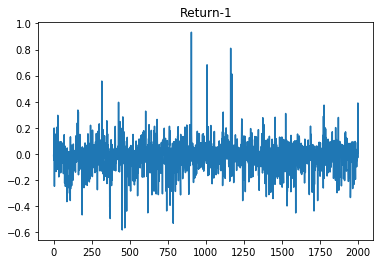

In [26]:
import matplotlib.pyplot as plt
import pandas as pd


x,y = zip(*total_returns_list)
z = [y_i-1 for y_i in y]
z = pd.DataFrame(z)
z = z[z<=25]

plt.plot(x,z)
plt.title('Return-1')
plt.show()

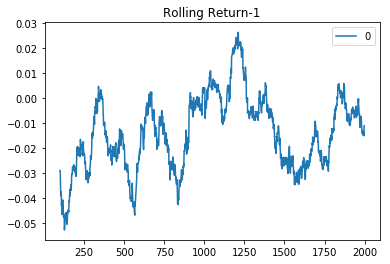

In [18]:
rolling_z = z.rolling(100).mean()
rolling_plot = rolling_z.plot(title='Rolling Return-1')

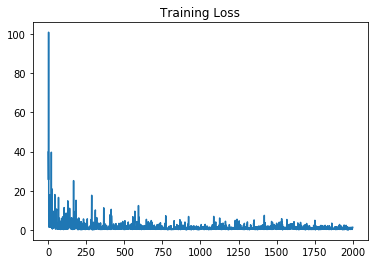

In [19]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

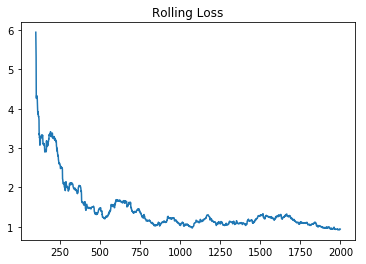

In [20]:
ep,reward = zip(*loss_list)
loss = pd.DataFrame(list(loss))
plt.plot(ep[:],loss.rolling(100).mean())
plt.title('Rolling Loss')
plt.show()

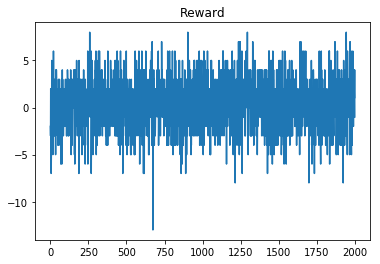

In [21]:
ep,reward = zip(*rewards_list)
plt.plot(ep[:],reward[:])
plt.title('Reward')
plt.show()

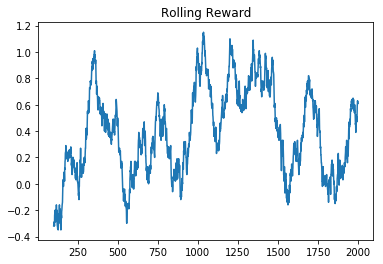

In [22]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
plt.plot(ep[:],reward.rolling(100).mean())
plt.title('Rolling Reward')
plt.show()

Run episode with trained model:

In [23]:
def run_episode(env): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()
    i=0

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            #print('Day {:.0f} Open_day = {:.2f}, Close_epi = {:.2f}, Close_epi/Open_day = {:2f}, Trade = {:.0f}, Daily Return = {:.2f}'.format(i,info_log['prices'].iloc[i]['Open'],info_log['prices'].iloc[-1]['Close'],info_log['close_open_returns'][i],info_log['trades'][i],info_log['daily_return']))
            i += 1
            if done:
                break

    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    
    
    
    print('Return: {:.5f}'.format(info_log['total_return']))
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(17,4))
    #Plot Prices
    plt.xticks(rotation=90)
    plt.grid(color='k', linestyle='--', linewidth=0.1)
    plt.ylim(min(plt_df.Close)*0.98, max(plt_df.Close)*1.02)
    plt.plot(plt_df.index,plt_df.Close,color='black')
    #Plot Buys
    plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Close,
                color='green',marker='^',s=100,zorder=3)
    #Plot Buys
    plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Close,
                color='red',marker='v',s=100,zorder=3)

    for i, txt in enumerate(plt_df.Trades):
        if txt !=0:
            plt.annotate(txt, (plt_df.index[i], plt_df.Close[i]+0.008*plt_df.Close[i]))
            plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Close[i]-0.015*plt_df.Close[i]))

    plt.show()
    return plt_df

Return: 0.88867


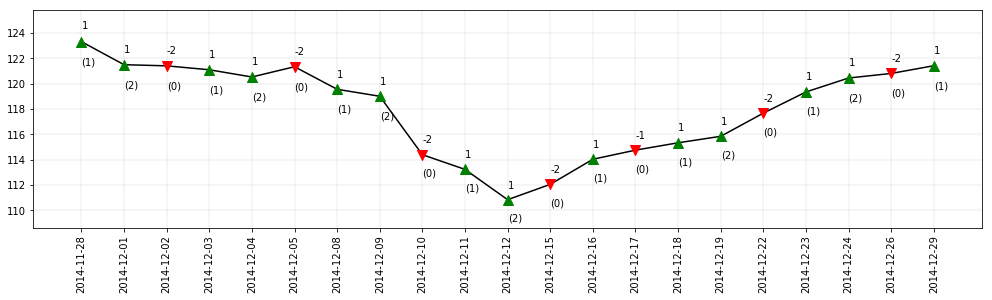

Return: 1.05125


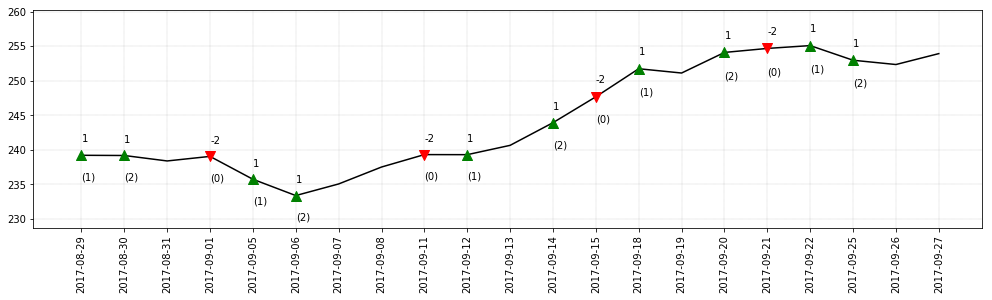

Return: 1.08735


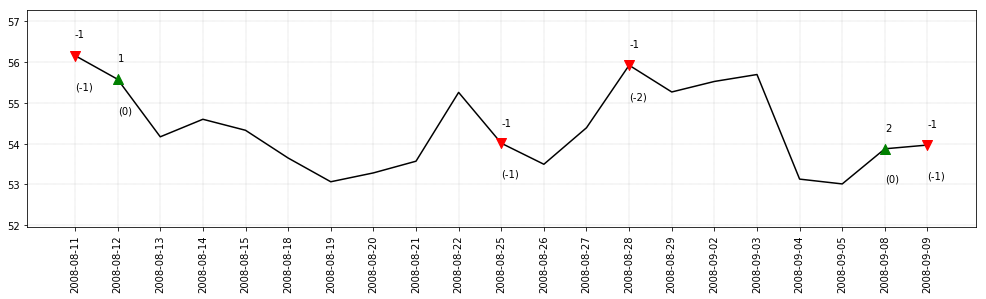

Return: 1.03385


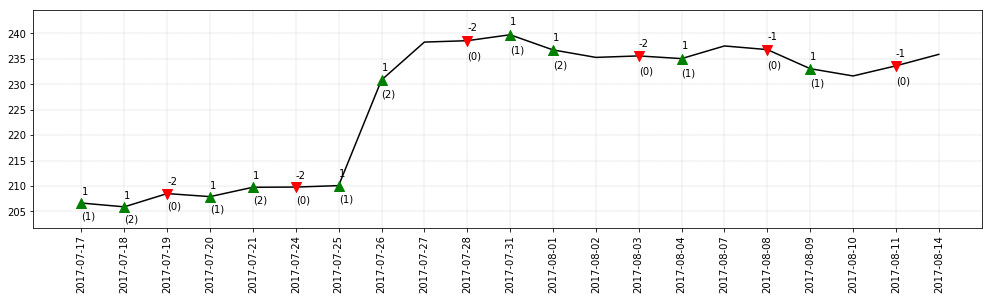

Return: 0.99126


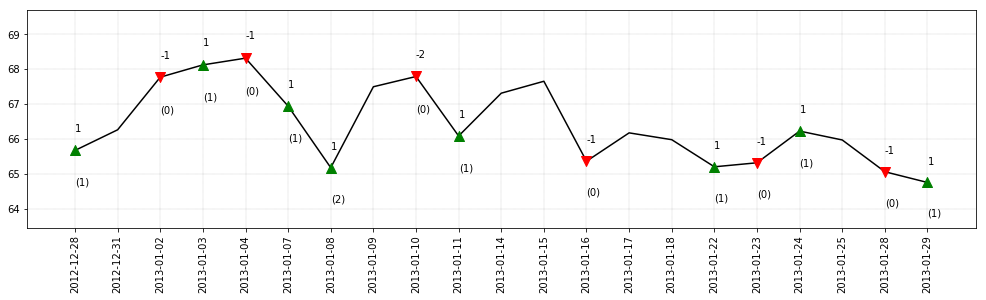

Return: 1.05672


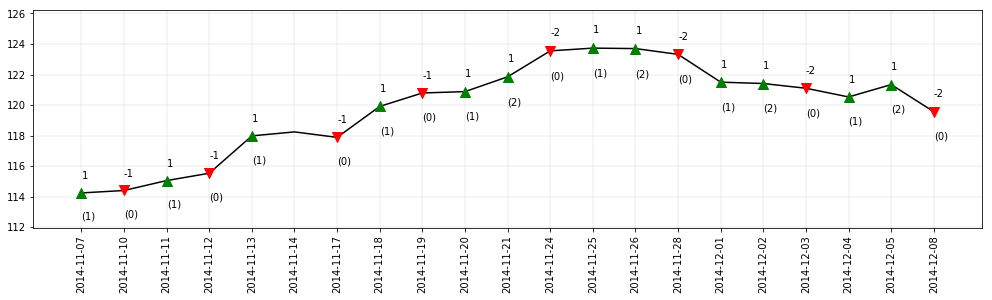

Return: 1.02747


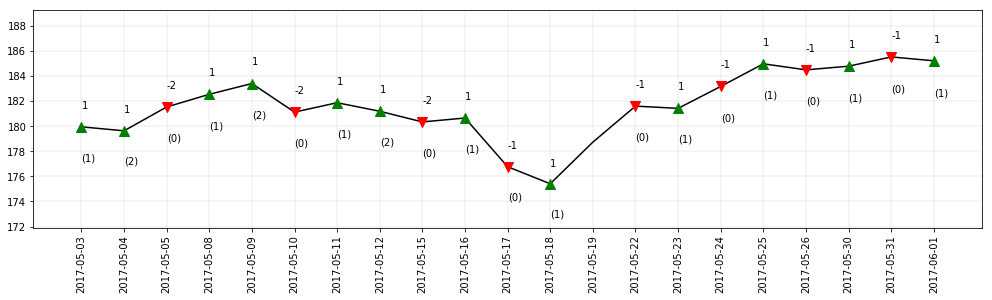

Return: 1.00114


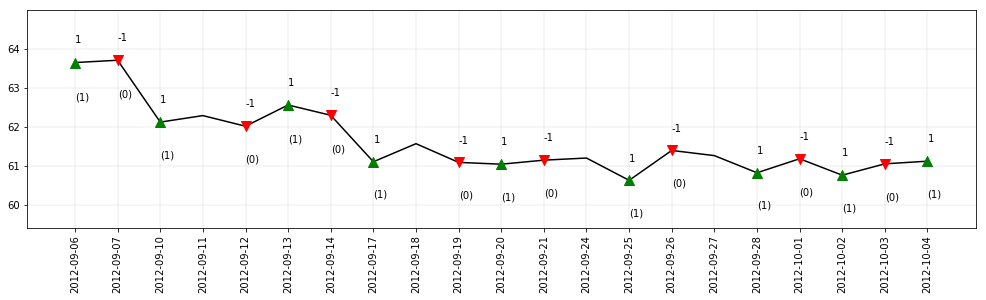

Return: 0.98270


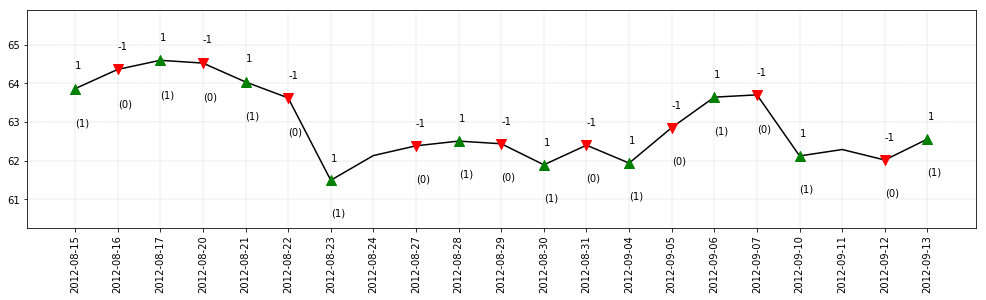

Return: 1.05794


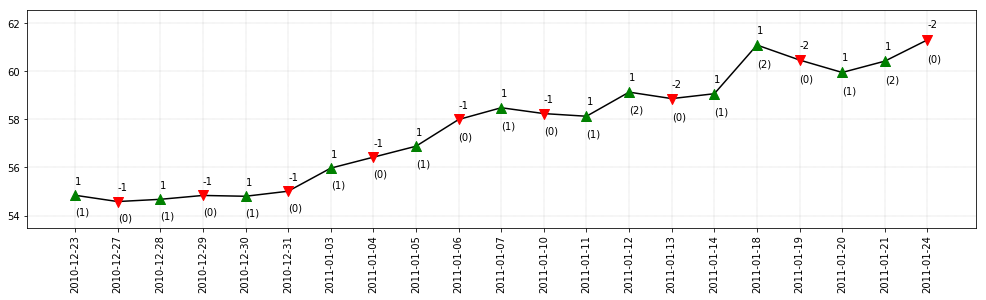

Return: 1.05704


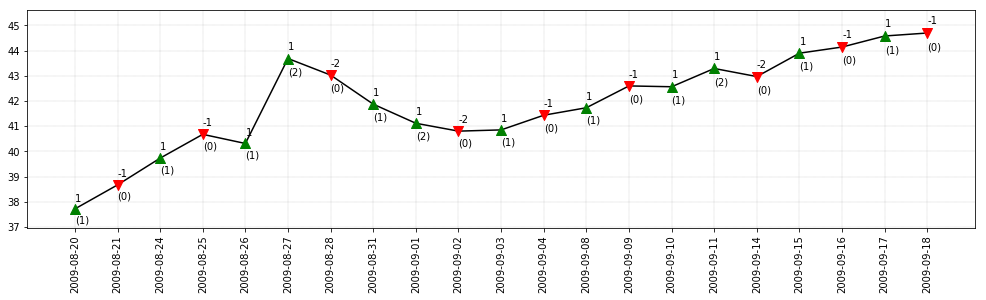

Return: 0.87788


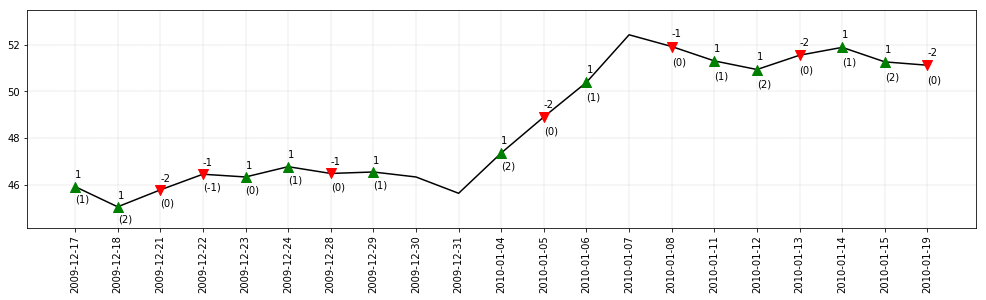

Return: 0.87528


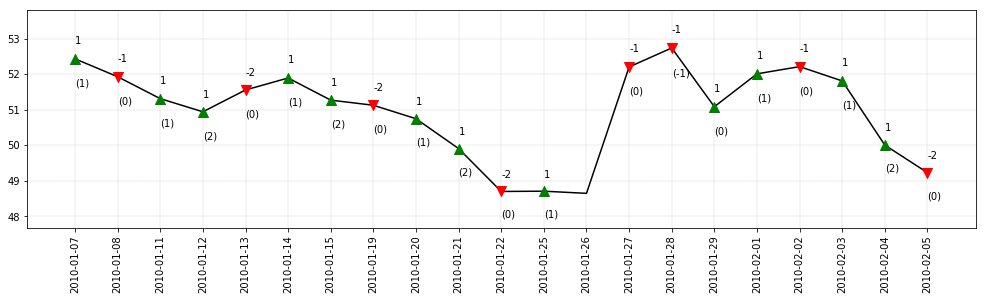

Return: 0.99829


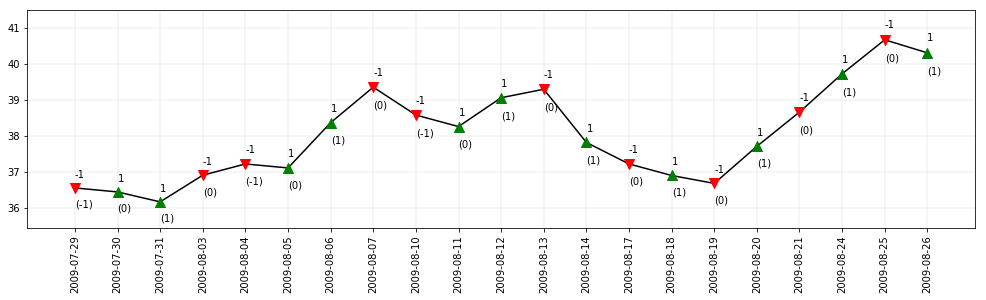

Return: 1.04171


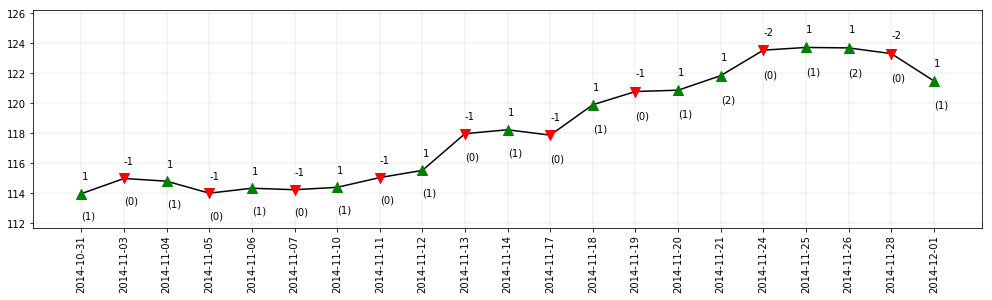

Return: 0.95934


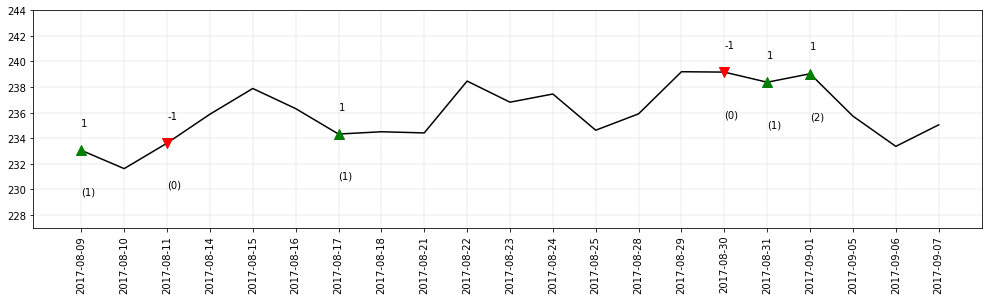

Return: 1.03785


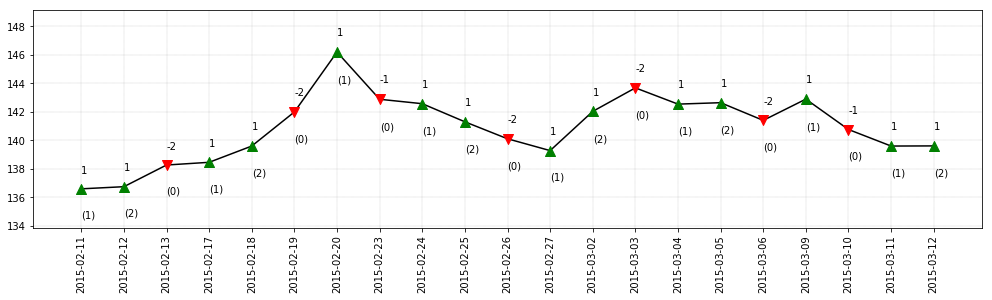

Return: 0.69518


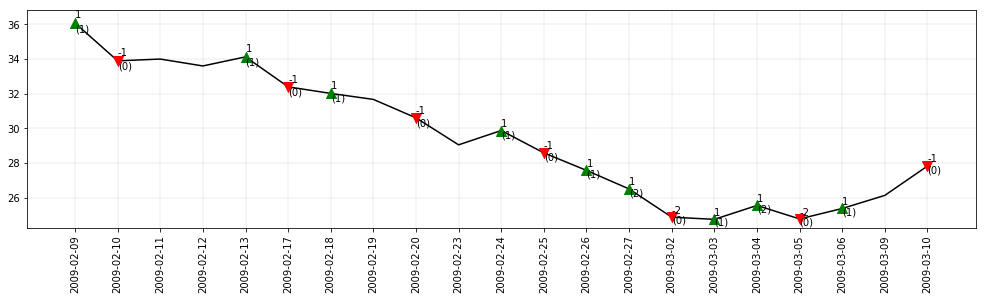

Return: 0.94474


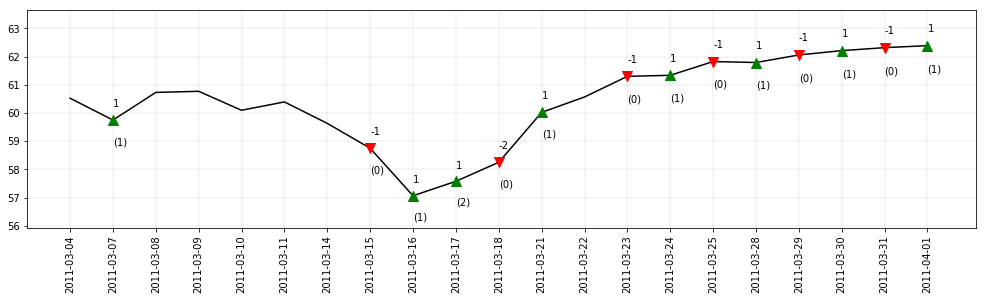

Return: 0.97511


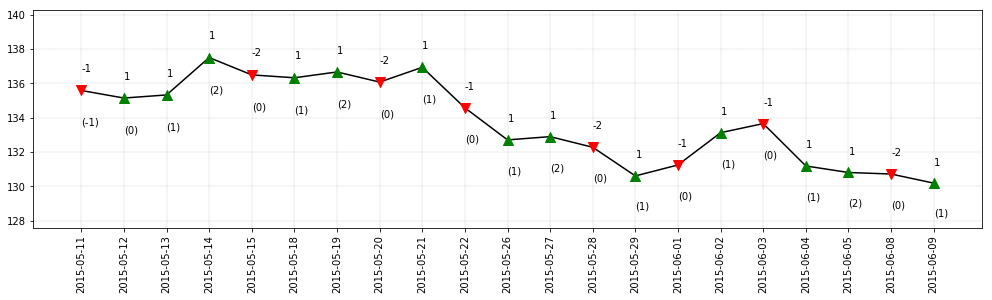

In [24]:
episode_count = 20

for i in range(episode_count):
    a =   run_episode(env)
    


In [25]:
a

,Open,High,Low,Close,Volume,OpenInt,Trades,Pos,Actions
Date,,,,,,,,,
2015-05-11,135.17,136.41,134.88,135.59,4270690,0,-1,-1,-1
2015-05-12,134.71,135.76,133.84,135.15,3813221,0,1,0,1
2015-05-13,135.13,136.19,134.86,135.33,2883913,0,1,1,1
2015-05-14,136.50,137.77,136.28,137.51,3761521,0,1,2,1
2015-05-15,137.43,137.82,136.00,136.50,3624924,0,-2,0,-1
2015-05-18,136.50,136.84,135.97,136.33,2316849,0,1,1,1
2015-05-19,136.78,137.34,136.35,136.67,2546246,0,1,2,1
2015-05-20,136.75,136.93,135.78,136.08,2263947,0,-2,0,-1
2015-05-21,136.21,137.28,135.78,136.94,2879837,0,1,1,1
